# 0.0.IMPORTS

In [1]:
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns
import numpy             as np
import statsmodels.api   as sm

from io                          import StringIO

from statsmodels.stats.stattools import durbin_watson


import inflection
import os

# 0.1. Helper Function

In [2]:
def type_NA(data):
    type_data = data.dtypes
    sum_na    = data.isna().sum()
    per_na    = data.isna().mean()
    
    metrics = pd.DataFrame({'Type':type_data, 'number na': sum_na, 'percent na':per_na})
    
    return metrics

def statistics_info(data):

    num_data = data.select_dtypes(include=['int', 'float'])

    # Central Tendency
    mean = num_data.apply(np.mean)
    q50 = num_data.quantile(0.5)

    # quantiles
    q25 = num_data.quantile(0.25)
    q50 = num_data.quantile(0.5)
    q75 = num_data.quantile(0.75)

    range_ = num_data.apply(lambda x: x.max() - x.min())
    count = num_data.count()

    # Dispersion
    min_ = num_data.apply(min)
    max_ = num_data.apply(max)
    std = num_data.apply(np.std)


    skew = num_data.apply(lambda x: x.skew())
    kurtosis = num_data.apply(lambda x: x.kurtosis())


    metrics = pd.DataFrame({'min': min_,'max':max_, 'range': range_ , 'quant25': q25, 'median':q50, 'quant75': q75,
                            'mean':mean, 'std':std,'skew':skew,'kurtosis':kurtosis,'Non-Null': count,})
    
    return (np.round(metrics,1))



def jupyter_settings():
    %matplotlib inline
#    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 7]
#    plt.rcParams['font.size'] = 10
    sns.set(font_scale=2)

#    display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

In [3]:
jupyter_settings()

## 0.2. Loading data

In [4]:
file_path = 'data/raw/df_ready.csv'

In [5]:
df_raw = pd.read_csv(file_path, low_memory=False)
df1 = df_raw.copy()

In [6]:
df1.head()

Unnamed: 0             Date_imp  Date_imp_d  Cluster                 Category_name                                               name  price  disc_price     merchant condition  Disc_percentage isSale  Imp_count    brand                                      p_description currency             dateAdded              dateSeen           dateUpdated imageURLs manufacturer   shipping                                         sourceURLs     weight Date_imp_d.1     Day_n  month    month_n  day  Week_Number  Zscore_1  price_std
0           4  2017-12-14 06:00:00  2017/12/14       35  speaker, portable, bluetooth  Boytone - 2500W 2.1-Ch. Home Theater System - ...  69.00       64.99  Walmart.com       New             0.06    Yes          1  Boytone  Stereos,Portable Bluetooth Speakers,TV, Video ...      USD  2015-05-18T14:14:56Z  2017-12-14T06:00:00Z  2018-06-13T19:39:02Z       NaN      Boytone  Expedited  https://www.walmart.com/ip/BOYTONE-BT210FB-BLA...  14 pounds   2017/12/14  Thursday     12   December   14           50  0.001525   3.880725
1           5  2017-09-08 05:00:00  2017/09/08       35  speaker, portable, bluetooth  Boytone - 2500W 2.1-Ch. Home Theater System - ...  69.00       69.00  Walmart.com       New             0.00     No          1  Boytone  Stereos,Portable Bluetooth Speakers,TV, Video ...      USD  2015-05-18T14:14:56Z  2017-09-08T05:00:00Z  2018-06-13T19:39:02Z       NaN      Boytone  Expedited  https://www.walmart.com/ip/Boytone-BT-210F-Blu...  14 pounds   2017/09/08    Friday      9  September    8           36  0.001525   3.880725
2           6  2017-10-24 04:00:00  2017/10/24       35  speaker, portable, bluetooth  Boytone - 2500W 2.1-Ch. Home Theater System - ...  66.00       66.00  Walmart.com       New             0.00     No          1  Boytone  Stereos,Portable Bluetooth Speakers,TV, Video ...      USD  2015-05-18T14:14:56Z  2017-10-24T04:00:00Z  2018-06-13T19:39:02Z       NaN      Boytone  Expedited  https://www.walmart.com/ip/Boytone-BT-210F-Blu...  14 pounds   2017/10/24   Tuesday     10    October   24           43 -0.760844   3.880725
3           7  2017-08-15 15:00:00  2017/08/15       35  speaker, portable, bluetooth  Boytone - 2500W 2.1-Ch. Home Theater System - ...  74.99       74.99  Walmart.com       New             0.00     No          1  Boytone  Stereos,Portable Bluetooth Speakers,TV, Video ...      USD  2015-05-18T14:14:56Z  2017-08-15T15:00:00Z  2018-06-13T19:39:02Z       NaN      Boytone      Value  https://www.walmart.com/ip/Boytone-BT-210F-Blu...  14 pounds   2017/08/15   Tuesday      8     August   15           33  1.523722   3.880725
4           8  2017-09-14 21:00:00  2017/09/14       35  speaker, portable, bluetooth  Boytone - 2500W 2.1-Ch. Home Theater System - ...  69.99       69.99  Walmart.com       New             0.00     No          1  Boytone  Stereos,Portable Bluetooth Speakers,TV, Video ...      USD  2015-05-18T14:14:56Z  2017-09-14T21:00:00Z  2018-06-13T19:39:02Z       NaN      Boytone  Expedited  https://www.walmart.com/ip/Boytone-BT-210F-Blu...  14 pounds   2017/09/14  Thursday      9  September   14           37  0.253107   3.880725

# 1.0. Description of the data

## 1.0. Description of the data

## 1.2. Rename Columns

In [8]:
cols_old = ['Unnamed: 0', 'Date_imp', 'Date_imp_d', 'Cluster', 'Category_name',
       'name', 'price', 'disc_price', 'merchant', 'condition',
       'Disc_percentage', 'isSale', 'Imp_count', 'brand', 'p_description',
       'currency', 'dateAdded', 'dateSeen', 'dateUpdated', 'imageURLs',
       'manufacturer', 'shipping', 'sourceURLs', 'weight', 'Date_imp_d.1',
       'Day_n', 'month', 'month_n', 'day', 'Week_Number', 'Zscore_1',
       'price_std']

snakecase = lambda x: inflection.underscore(x)
cols_new = list( map(snakecase, cols_old) )

df1.columns = cols_new

In [9]:
df1.columns

Index(['unnamed: 0', 'date_imp', 'date_imp_d', 'cluster', 'category_name',
       'name', 'price', 'disc_price', 'merchant', 'condition',
       'disc_percentage', 'is_sale', 'imp_count', 'brand', 'p_description',
       'currency', 'date_added', 'date_seen', 'date_updated', 'image_ur_ls',
       'manufacturer', 'shipping', 'source_ur_ls', 'weight', 'date_imp_d.1',
       'day_n', 'month', 'month_n', 'day', 'week_number', 'zscore_1',
       'price_std'],
      dtype='object')

In [10]:
df1 = df1.drop(columns=['unnamed: 0', 'date_imp', 'cluster', 'condition',
                       'disc_percentage', 'is_sale', 'imp_count', 'p_description',
                       'currency', 'date_added', 'date_seen', 'date_updated', 'image_ur_ls',
                       'shipping', 'source_ur_ls', 'weight', 'date_imp_d.1', 'zscore_1',
                       'price_std'])

In [11]:
df1.head()

date_imp_d                 category_name                                               name  price  disc_price     merchant    brand manufacturer     day_n  month    month_n  day  week_number
0  2017/12/14  speaker, portable, bluetooth  Boytone - 2500W 2.1-Ch. Home Theater System - ...  69.00       64.99  Walmart.com  Boytone      Boytone  Thursday     12   December   14           50
1  2017/09/08  speaker, portable, bluetooth  Boytone - 2500W 2.1-Ch. Home Theater System - ...  69.00       69.00  Walmart.com  Boytone      Boytone    Friday      9  September    8           36
2  2017/10/24  speaker, portable, bluetooth  Boytone - 2500W 2.1-Ch. Home Theater System - ...  66.00       66.00  Walmart.com  Boytone      Boytone   Tuesday     10    October   24           43
3  2017/08/15  speaker, portable, bluetooth  Boytone - 2500W 2.1-Ch. Home Theater System - ...  74.99       74.99  Walmart.com  Boytone      Boytone   Tuesday      8     August   15           33
4  2017/09/14  speaker, portable, bluetooth  Boytone - 2500W 2.1-Ch. Home Theater System - ...  69.99       69.99  Walmart.com  Boytone      Boytone  Thursday      9  September   14           37

## 1.2. Data Dimensions

In [12]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of columns {}'.format(df1.shape[1]))

Number of Rows: 23151
Number of columns 13


## 1.3. Data types and check NA

In [13]:
m = type_NA(df1)
m

Type  number na  percent na
date_imp_d      object          0    0.000000
category_name   object          0    0.000000
name            object          0    0.000000
price          float64          0    0.000000
disc_price     float64          0    0.000000
merchant        object          0    0.000000
brand           object          0    0.000000
manufacturer    object      10639    0.459548
day_n           object          0    0.000000
month            int64          0    0.000000
month_n         object          0    0.000000
day              int64          0    0.000000
week_number      int64          0    0.000000

## 1.5. Fillout NA

## 1.6. Change type

In [14]:
df1['date_imp_d'] = pd.to_datetime(df1['date_imp_d'])

## 1.7. Descriptive Statistical

In [15]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64'])

In [16]:
des_num = statistics_info(df1)

In [17]:
des_num

min      max    range  quant25  median  quant75   mean    std  skew  kurtosis  Non-Null
price        1.0  10880.0  10879.0     83.0   200.0    540.0  513.0  859.1   4.6      34.4     23151
disc_price   1.0  10880.0  10879.0     80.0   199.0    516.5  494.1  808.6   4.7      39.6     23151
month        1.0     12.0     11.0      6.0     8.0      9.0    7.7    2.6  -0.1      -0.6     23151
day          1.0     31.0     30.0      7.0    16.0     24.0   15.7    9.7   0.0      -1.3     23151
week_number  1.0     51.0     50.0     23.0    32.0     38.0   31.3   11.3  -0.3      -0.6     23151

# 2.0 EDA

In [18]:
df2 =df1.copy()

In [19]:
df2.head()

date_imp_d                 category_name                                               name  price  disc_price     merchant    brand manufacturer     day_n  month    month_n  day  week_number
0 2017-12-14  speaker, portable, bluetooth  Boytone - 2500W 2.1-Ch. Home Theater System - ...  69.00       64.99  Walmart.com  Boytone      Boytone  Thursday     12   December   14           50
1 2017-09-08  speaker, portable, bluetooth  Boytone - 2500W 2.1-Ch. Home Theater System - ...  69.00       69.00  Walmart.com  Boytone      Boytone    Friday      9  September    8           36
2 2017-10-24  speaker, portable, bluetooth  Boytone - 2500W 2.1-Ch. Home Theater System - ...  66.00       66.00  Walmart.com  Boytone      Boytone   Tuesday     10    October   24           43
3 2017-08-15  speaker, portable, bluetooth  Boytone - 2500W 2.1-Ch. Home Theater System - ...  74.99       74.99  Walmart.com  Boytone      Boytone   Tuesday      8     August   15           33
4 2017-09-14  speaker, portable, bluetooth  Boytone - 2500W 2.1-Ch. Home Theater System - ...  69.99       69.99  Walmart.com  Boytone      Boytone  Thursday      9  September   14           37

## 2.1. Qual o merchant que mais vendeu?

<Axes: xlabel='merchant', ylabel='date_imp_d'>

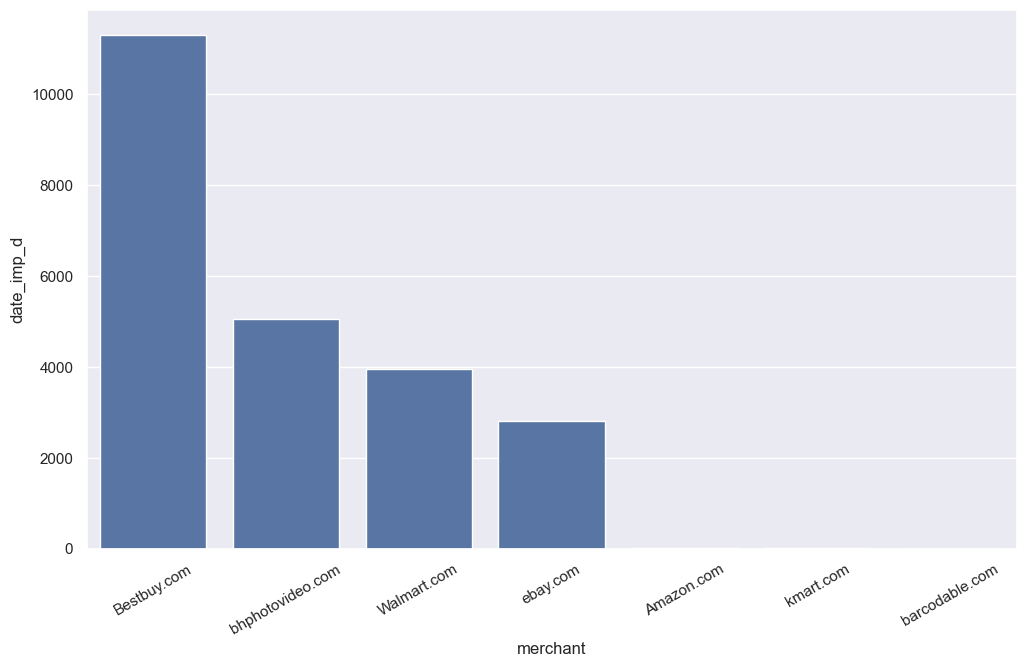

In [20]:
aux1 = df2[['date_imp_d', 'merchant']].groupby('merchant').count().reset_index().sort_values(by='date_imp_d', ascending=False)
plt.xticks(rotation=30)
sns.barplot(x='merchant', y='date_imp_d', data=aux1)

In [20]:
#seleção de lojas
df_best     = df2[df2['merchant'] == 'Bestbuy.com']
df_bhp      = df2[df2['merchant'] == 'bhphotovideo.com']
df_walmart  = df2[df2['merchant'] == 'Walmart.com']
df_ebay     = df2[df2['merchant'] == 'ebay.com']

## 2.2. Qual a categoria mais vendida?

### 2.2.1. Categorias mais vendidas no geral?

<Axes: xlabel='category_name', ylabel='date_imp_d'>

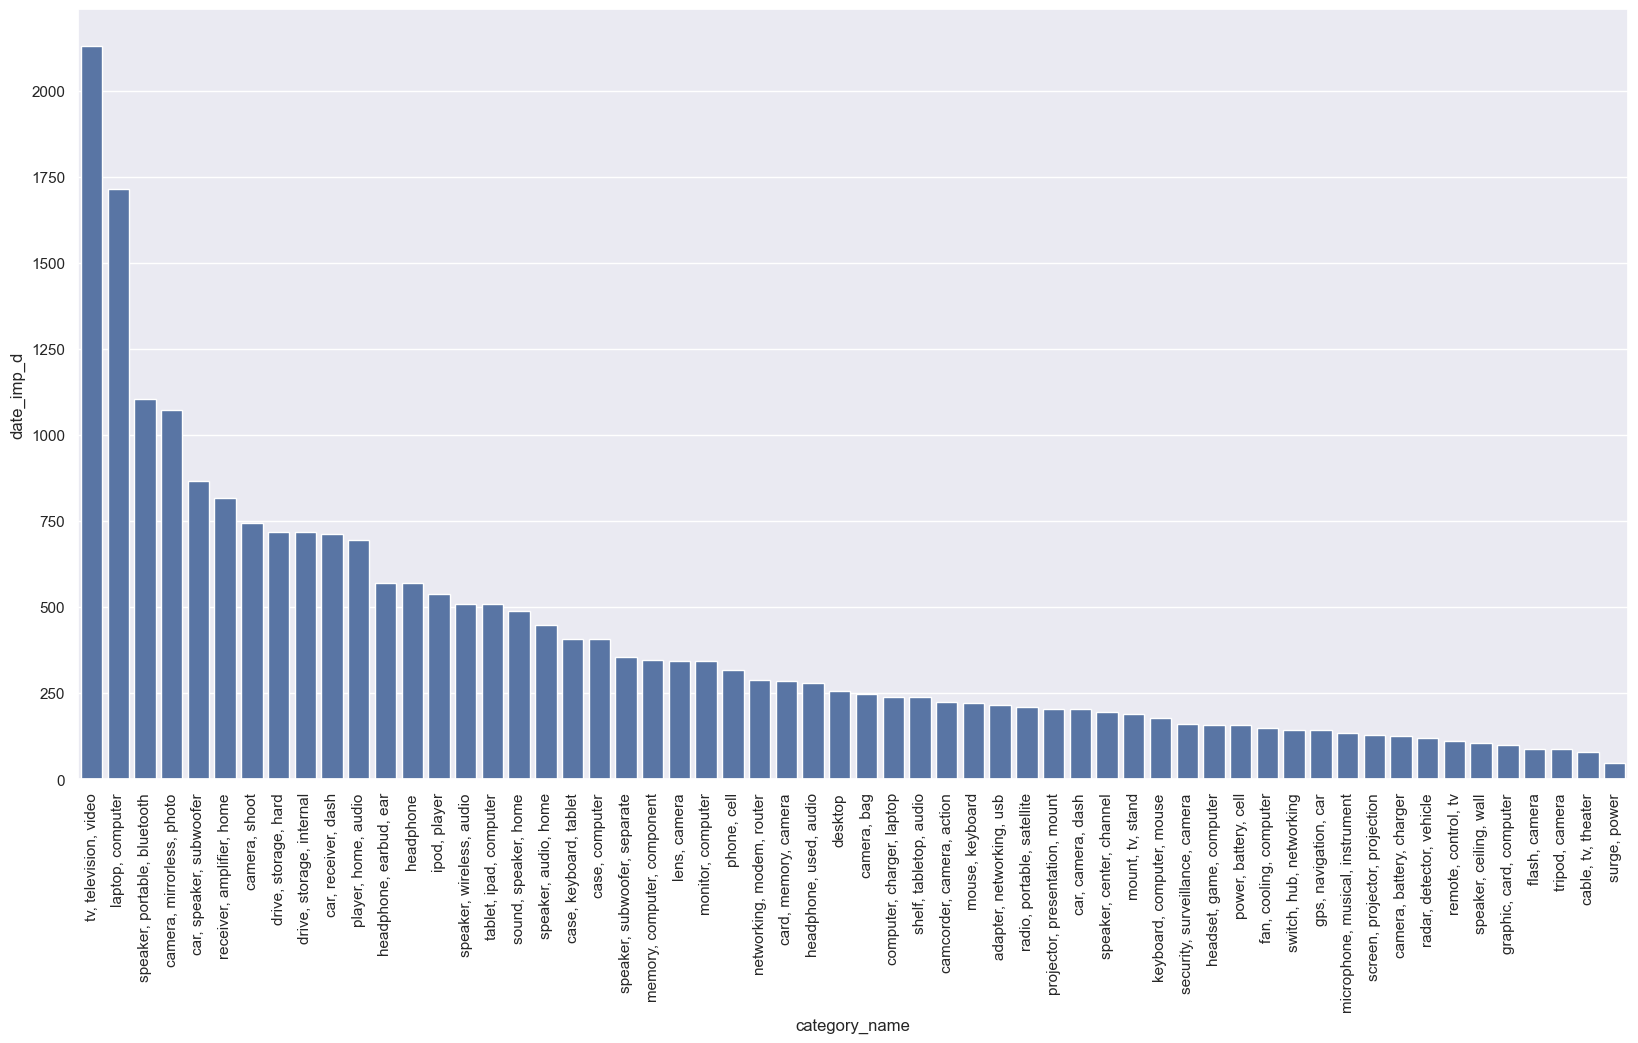

In [23]:
plt.figure(figsize=(20,10))
aux2 = df2[['date_imp_d', 'category_name']].groupby('category_name').count().reset_index().sort_values(by='date_imp_d', ascending=False)
plt.xticks(rotation=90)
sns.barplot(x='category_name', y='date_imp_d', data=aux2)

### 2.2.2 Categorias mais vendidas por loja?

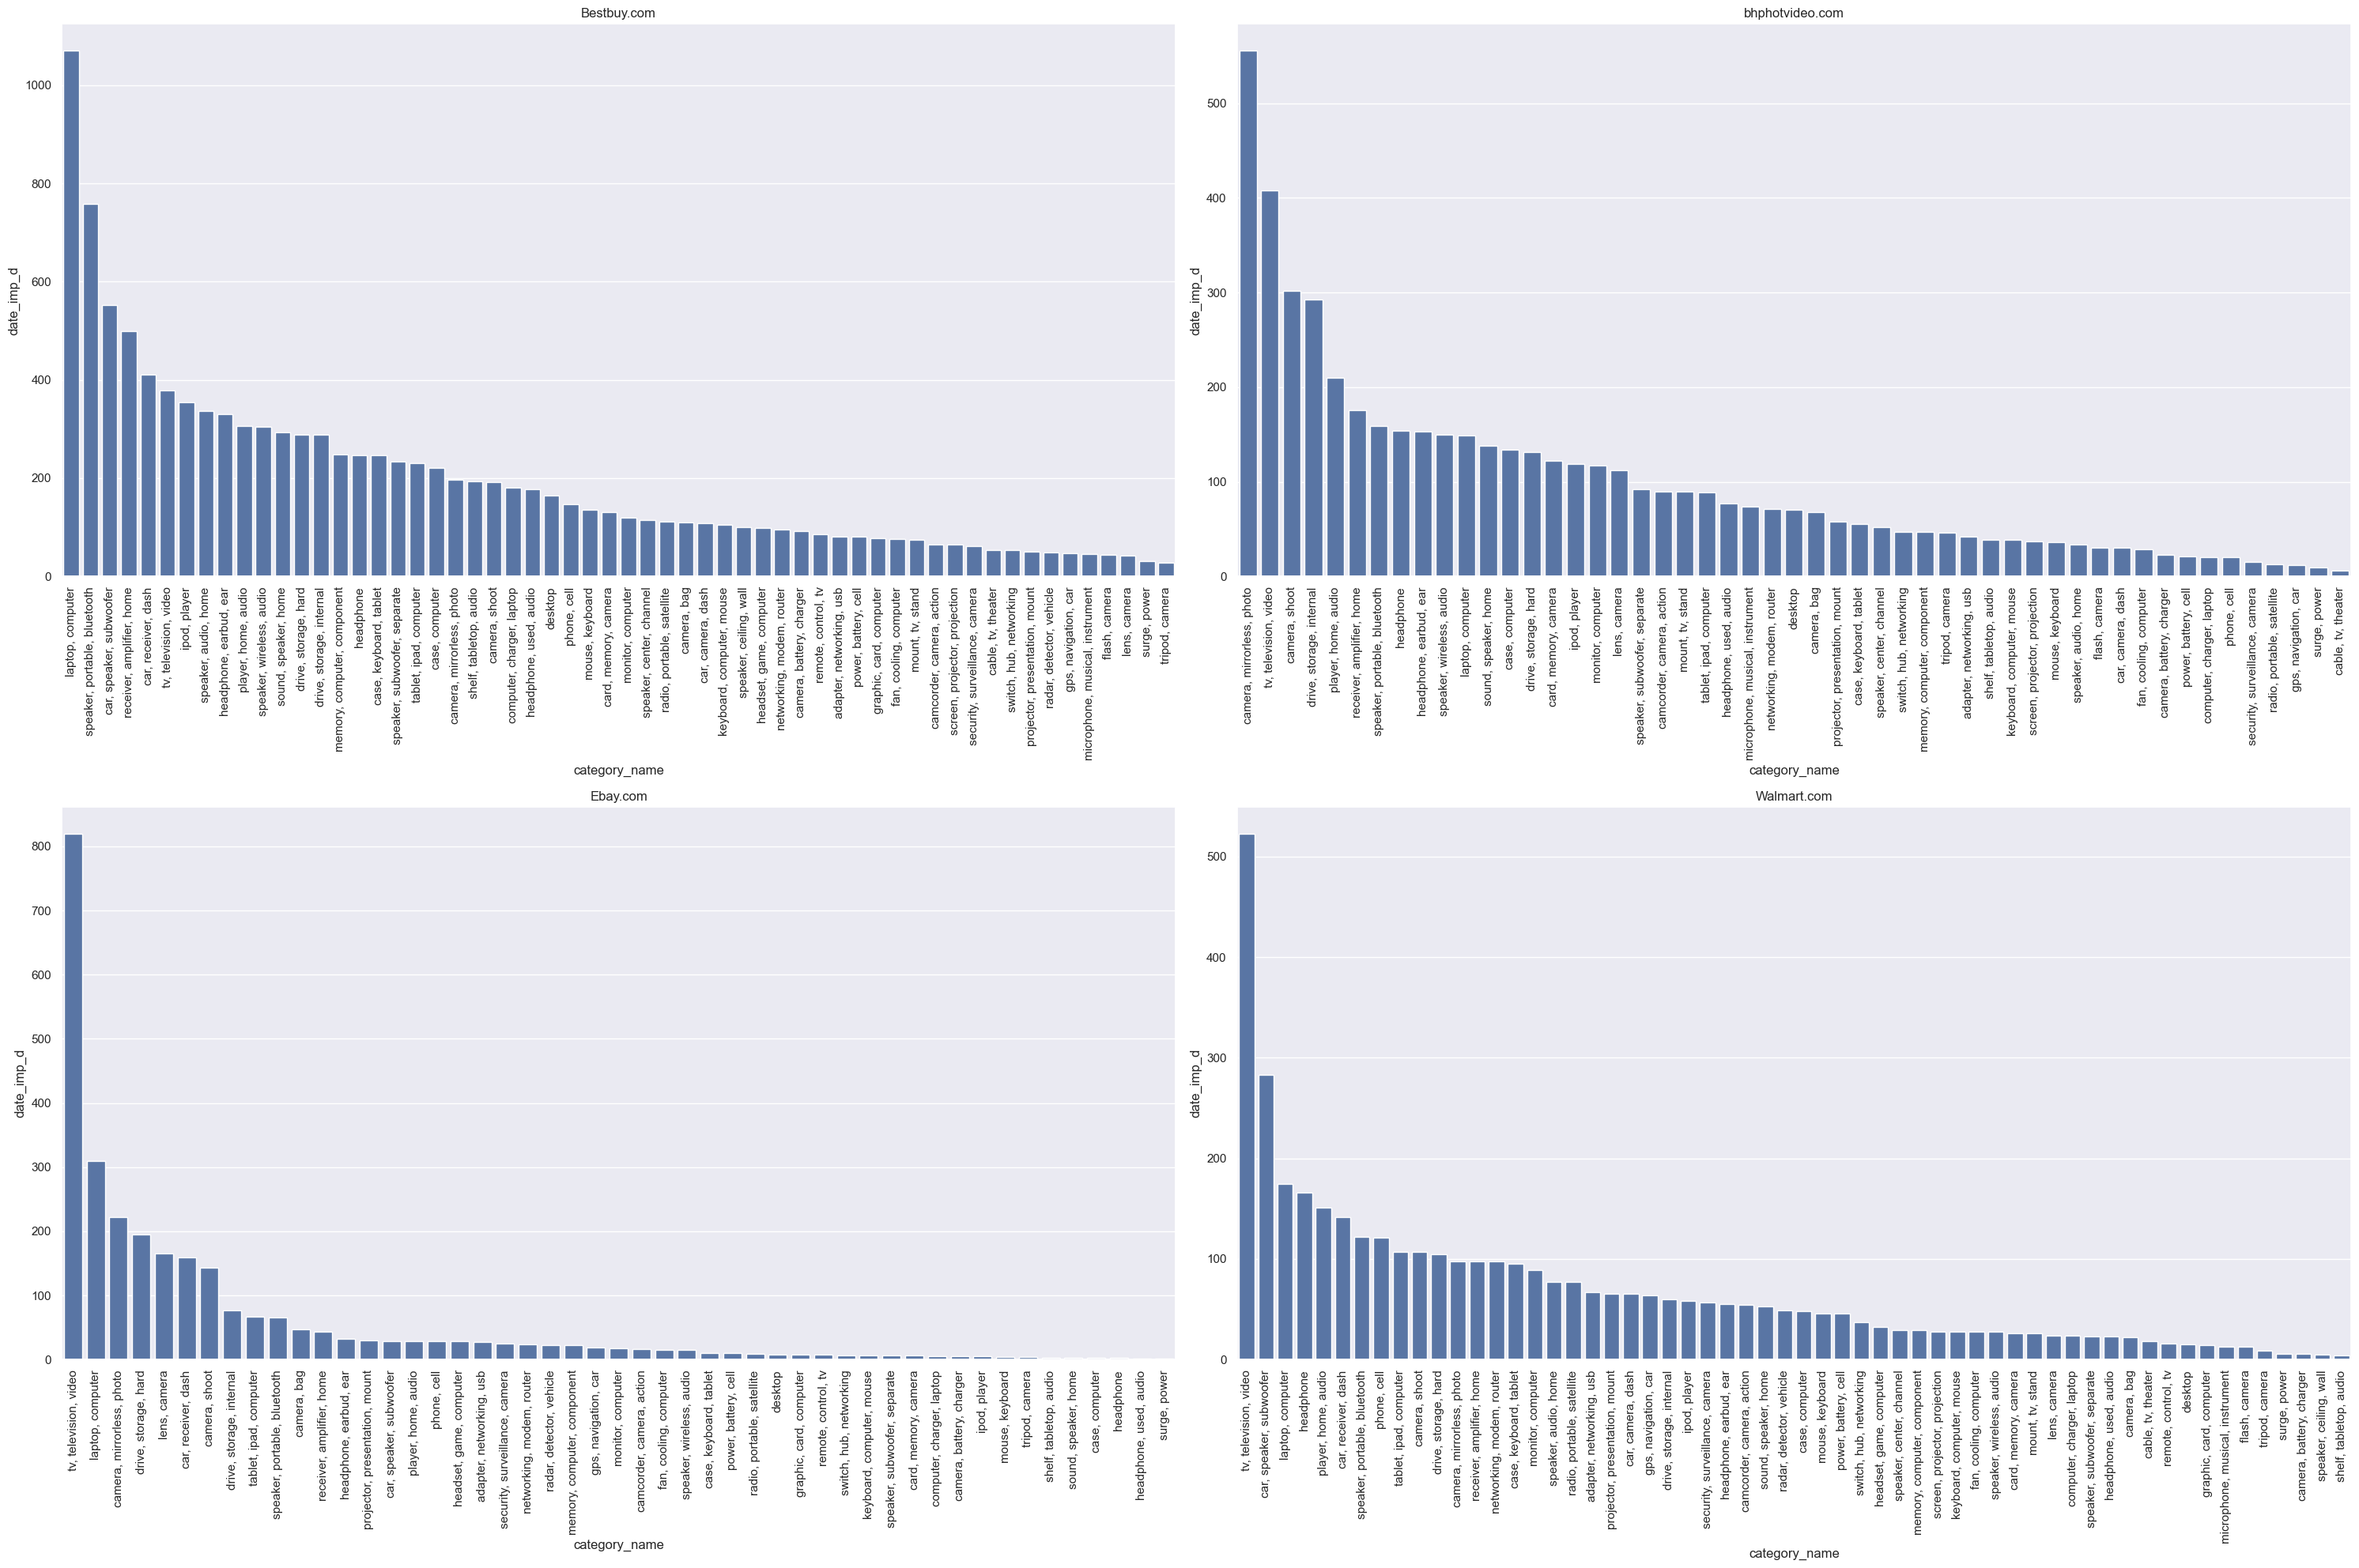

In [24]:
plt.figure(figsize=(30,20))


plt.subplot(2,2,1)
aux3 = df_best[['date_imp_d', 'category_name']].groupby('category_name').count().reset_index().sort_values(by='date_imp_d', ascending=False)
plt.xticks(rotation=90)
plt.title('Bestbuy.com')
sns.barplot(x='category_name', y='date_imp_d', data=aux3)

plt.subplot(2,2,2)
aux4 = df_bhp[['date_imp_d', 'category_name']].groupby('category_name').count().reset_index().sort_values(by='date_imp_d', ascending=False)
plt.xticks(rotation=90)
plt.title('bhphotvideo.com')
sns.barplot(x='category_name', y='date_imp_d', data=aux4)

plt.subplot(2,2,3)
aux5 = df_ebay[['date_imp_d', 'category_name']].groupby('category_name').count().reset_index().sort_values(by='date_imp_d', ascending=False)
plt.xticks(rotation=90)
plt.title('Ebay.com')
sns.barplot(x='category_name', y='date_imp_d', data=aux5)

plt.subplot(2,2,4)
aux6 = df_walmart[['date_imp_d', 'category_name']].groupby('category_name').count().reset_index().sort_values(by='date_imp_d', ascending=False)
plt.xticks(rotation=90)
plt.title('Walmart.com')
sns.barplot(x='category_name', y='date_imp_d', data=aux6)

plt.tight_layout()

## 2.3. Qual a marca mais vendida?

<Axes: xlabel='brand', ylabel='date_imp_d'>

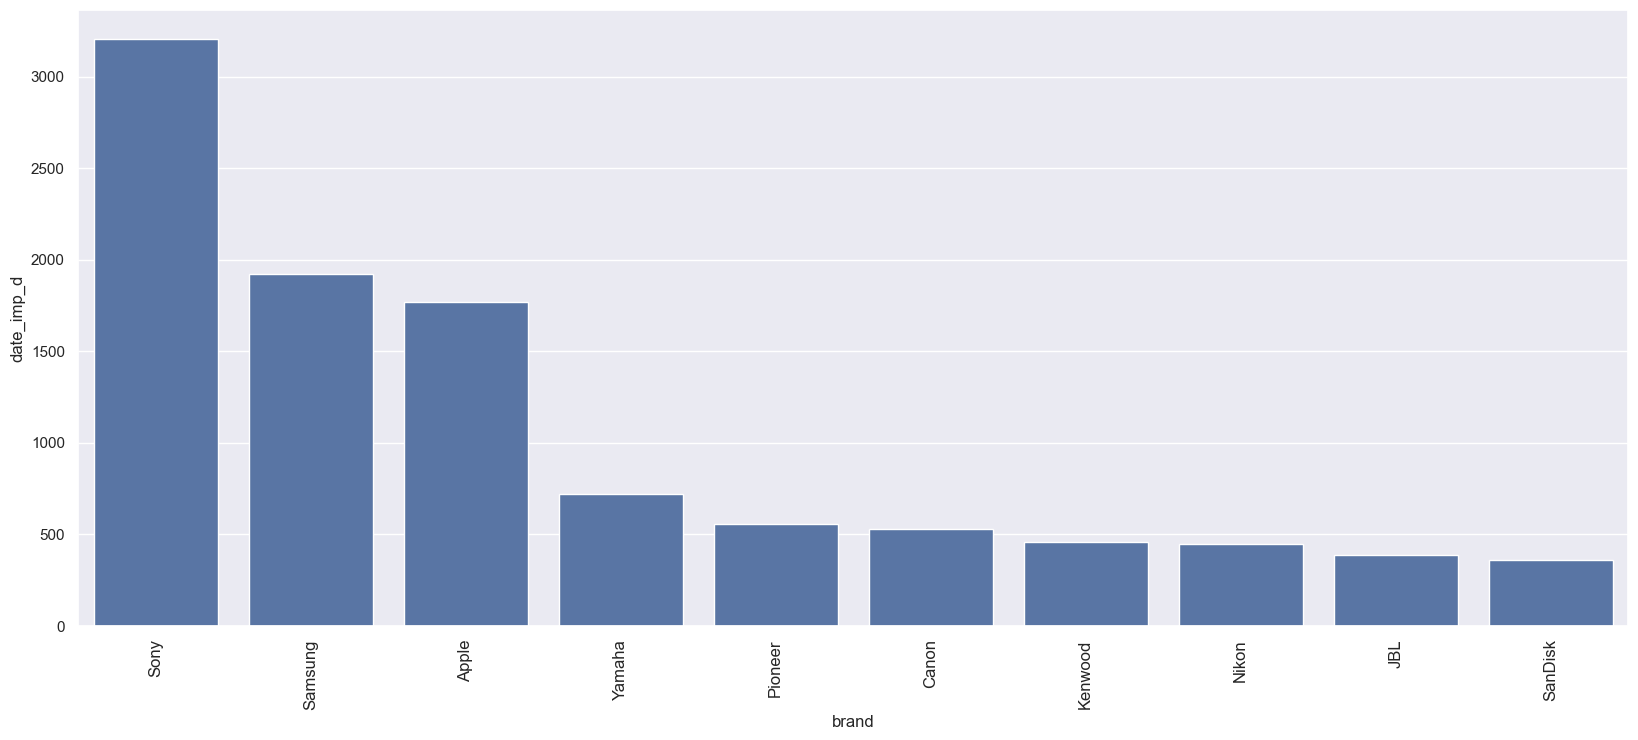

In [25]:
plt.figure(figsize=(20,8))
aux7 = df2[['date_imp_d', 'brand']].groupby('brand').count().reset_index().sort_values(by='date_imp_d', ascending=False)
plt.xticks(rotation=90, fontsize=12)
sns.barplot(x='brand', y='date_imp_d', data=aux7.head(10))

## 2.4. Quais os dias que mais vendem?

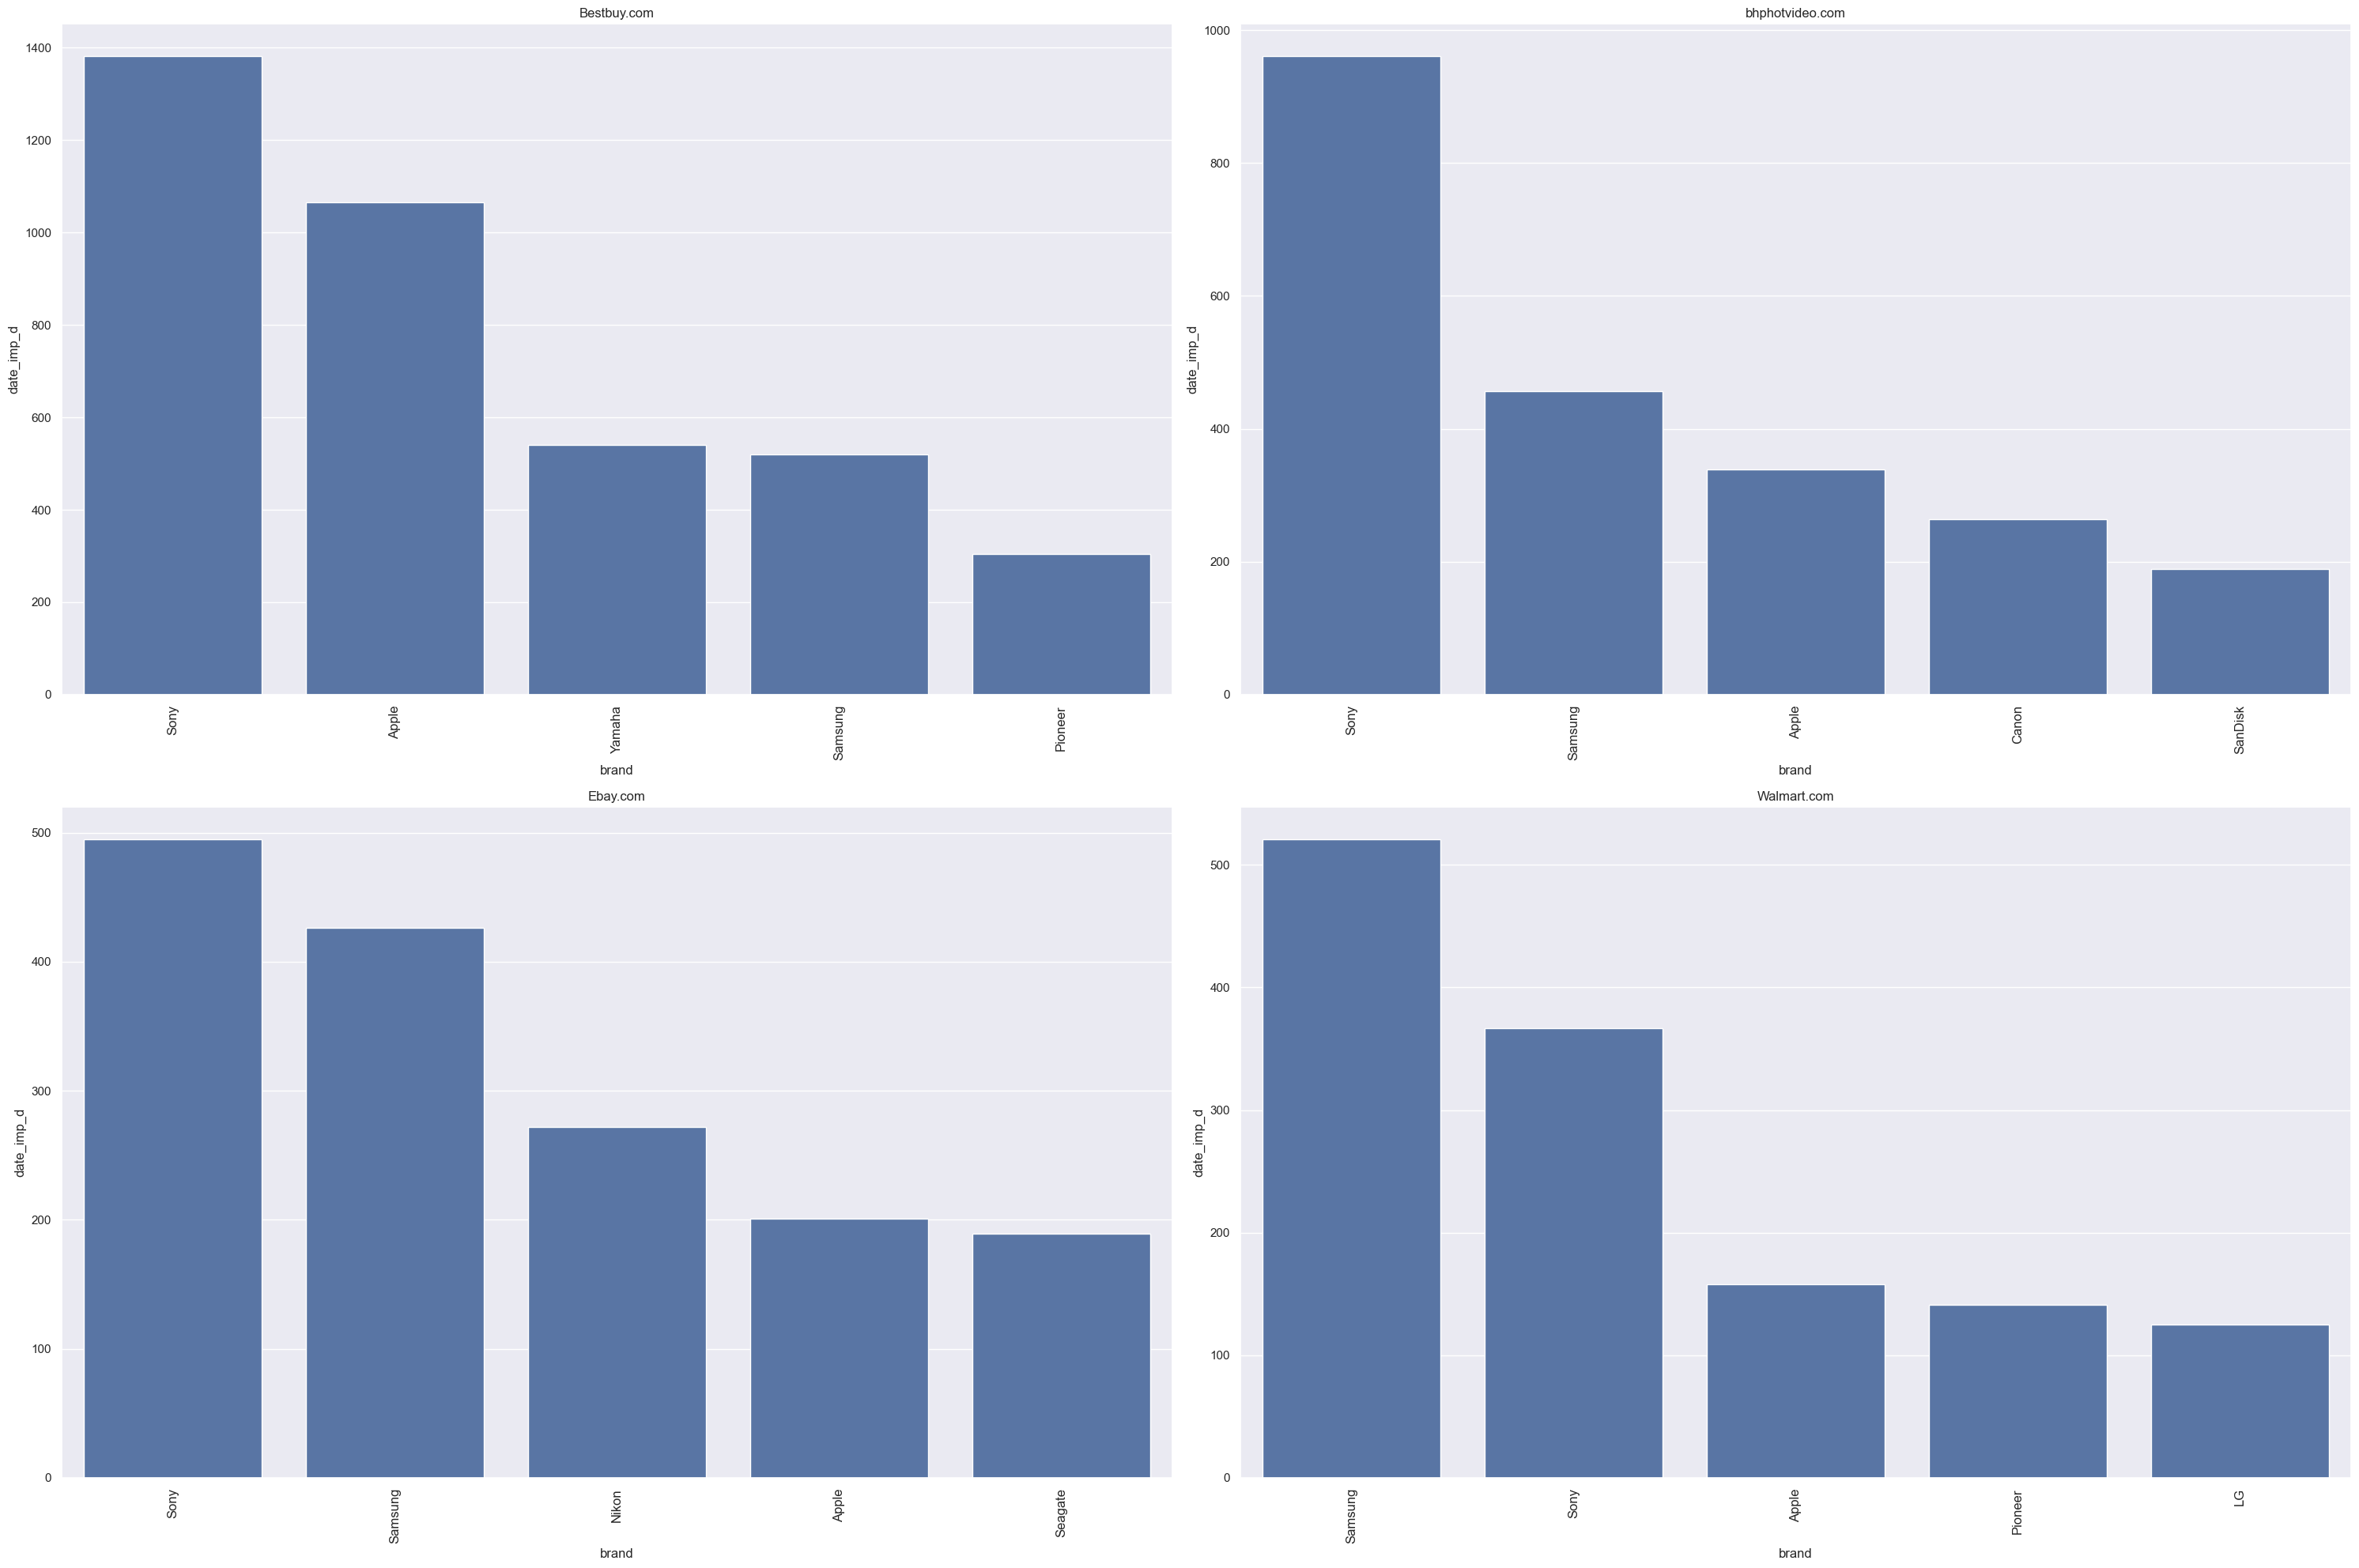

In [26]:
plt.figure(figsize=(30,20))


plt.subplot(2,2,1)
aux8 = df_best[['date_imp_d', 'brand']].groupby('brand').count().reset_index().sort_values(by='date_imp_d', ascending=False)
plt.xticks(rotation=90, fontsize=12)
plt.title('Bestbuy.com')
sns.barplot(x='brand', y='date_imp_d', data=aux8.head())

plt.subplot(2,2,2)
aux9 = df_bhp[['date_imp_d', 'brand']].groupby('brand').count().reset_index().sort_values(by='date_imp_d', ascending=False)
plt.xticks(rotation=90, fontsize=12)
plt.title('bhphotvideo.com')
sns.barplot(x='brand', y='date_imp_d', data=aux9.head())

plt.subplot(2,2,3)
aux10 = df_ebay[['date_imp_d', 'brand']].groupby('brand').count().reset_index().sort_values(by='date_imp_d', ascending=False)
plt.xticks(rotation=90, fontsize=12)
plt.title('Ebay.com')
sns.barplot(x='brand', y='date_imp_d', data=aux10.head())

plt.subplot(2,2,4)
aux11 = df_walmart[['date_imp_d', 'brand']].groupby('brand').count().reset_index().sort_values(by='date_imp_d', ascending=False)
plt.xticks(rotation=90, fontsize=12)
plt.title('Walmart.com')
sns.barplot(x='brand', y='date_imp_d', data=aux11.head())

plt.tight_layout()

## 2.5. Quais os meses que mais vendem?

<Axes: xlabel='month_n', ylabel='date_imp_d'>

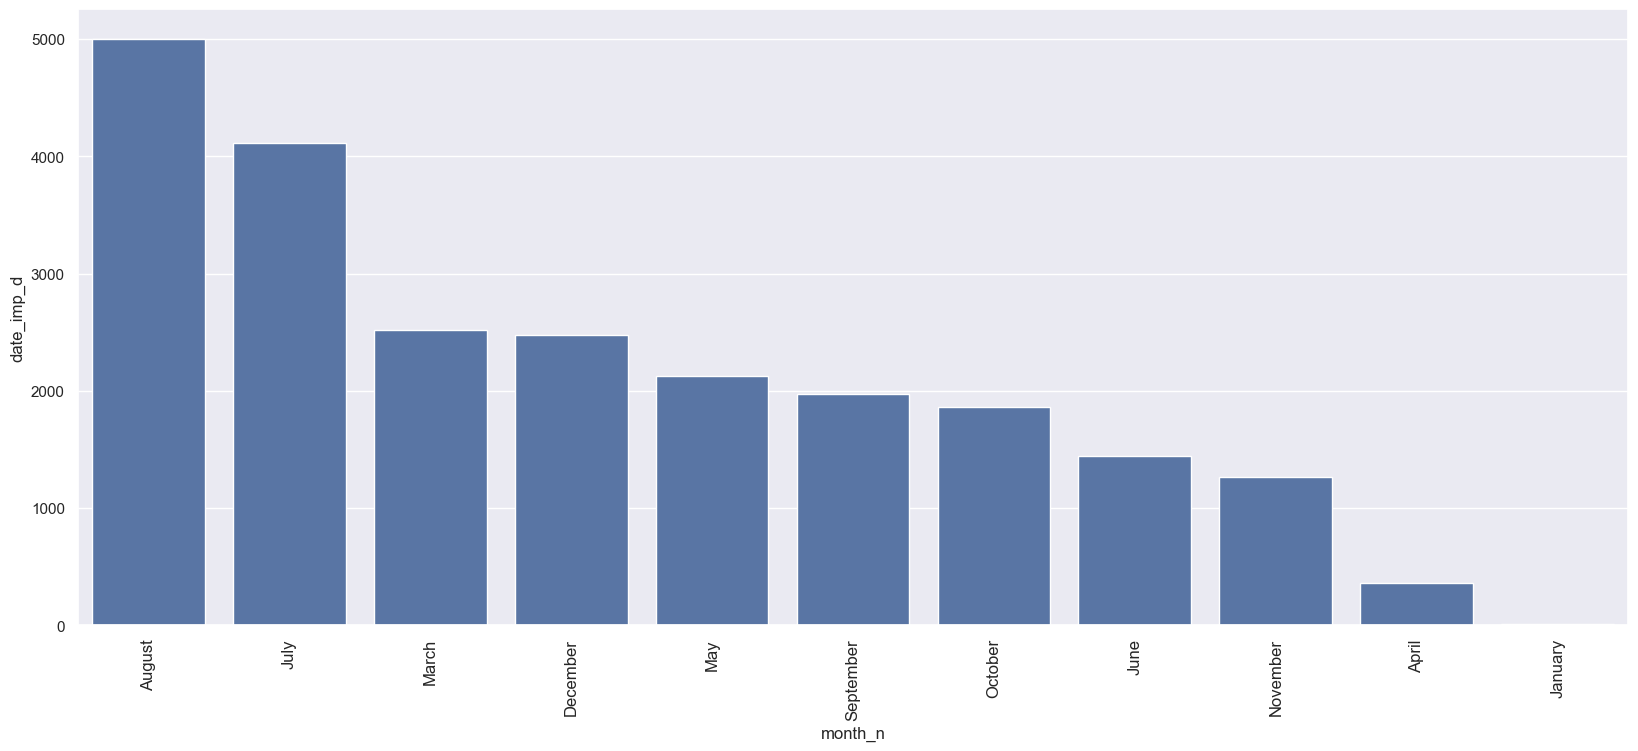

In [27]:
plt.figure(figsize=(20,8))
aux17 = df2[['date_imp_d', 'month_n']].groupby('month_n').count().reset_index().sort_values(by='date_imp_d', ascending=False)
plt.xticks(rotation=90, fontsize=12)
sns.barplot(x='month_n', y='date_imp_d', data=aux17)

## 2.6. Quais os meses que mais vendem por loja?

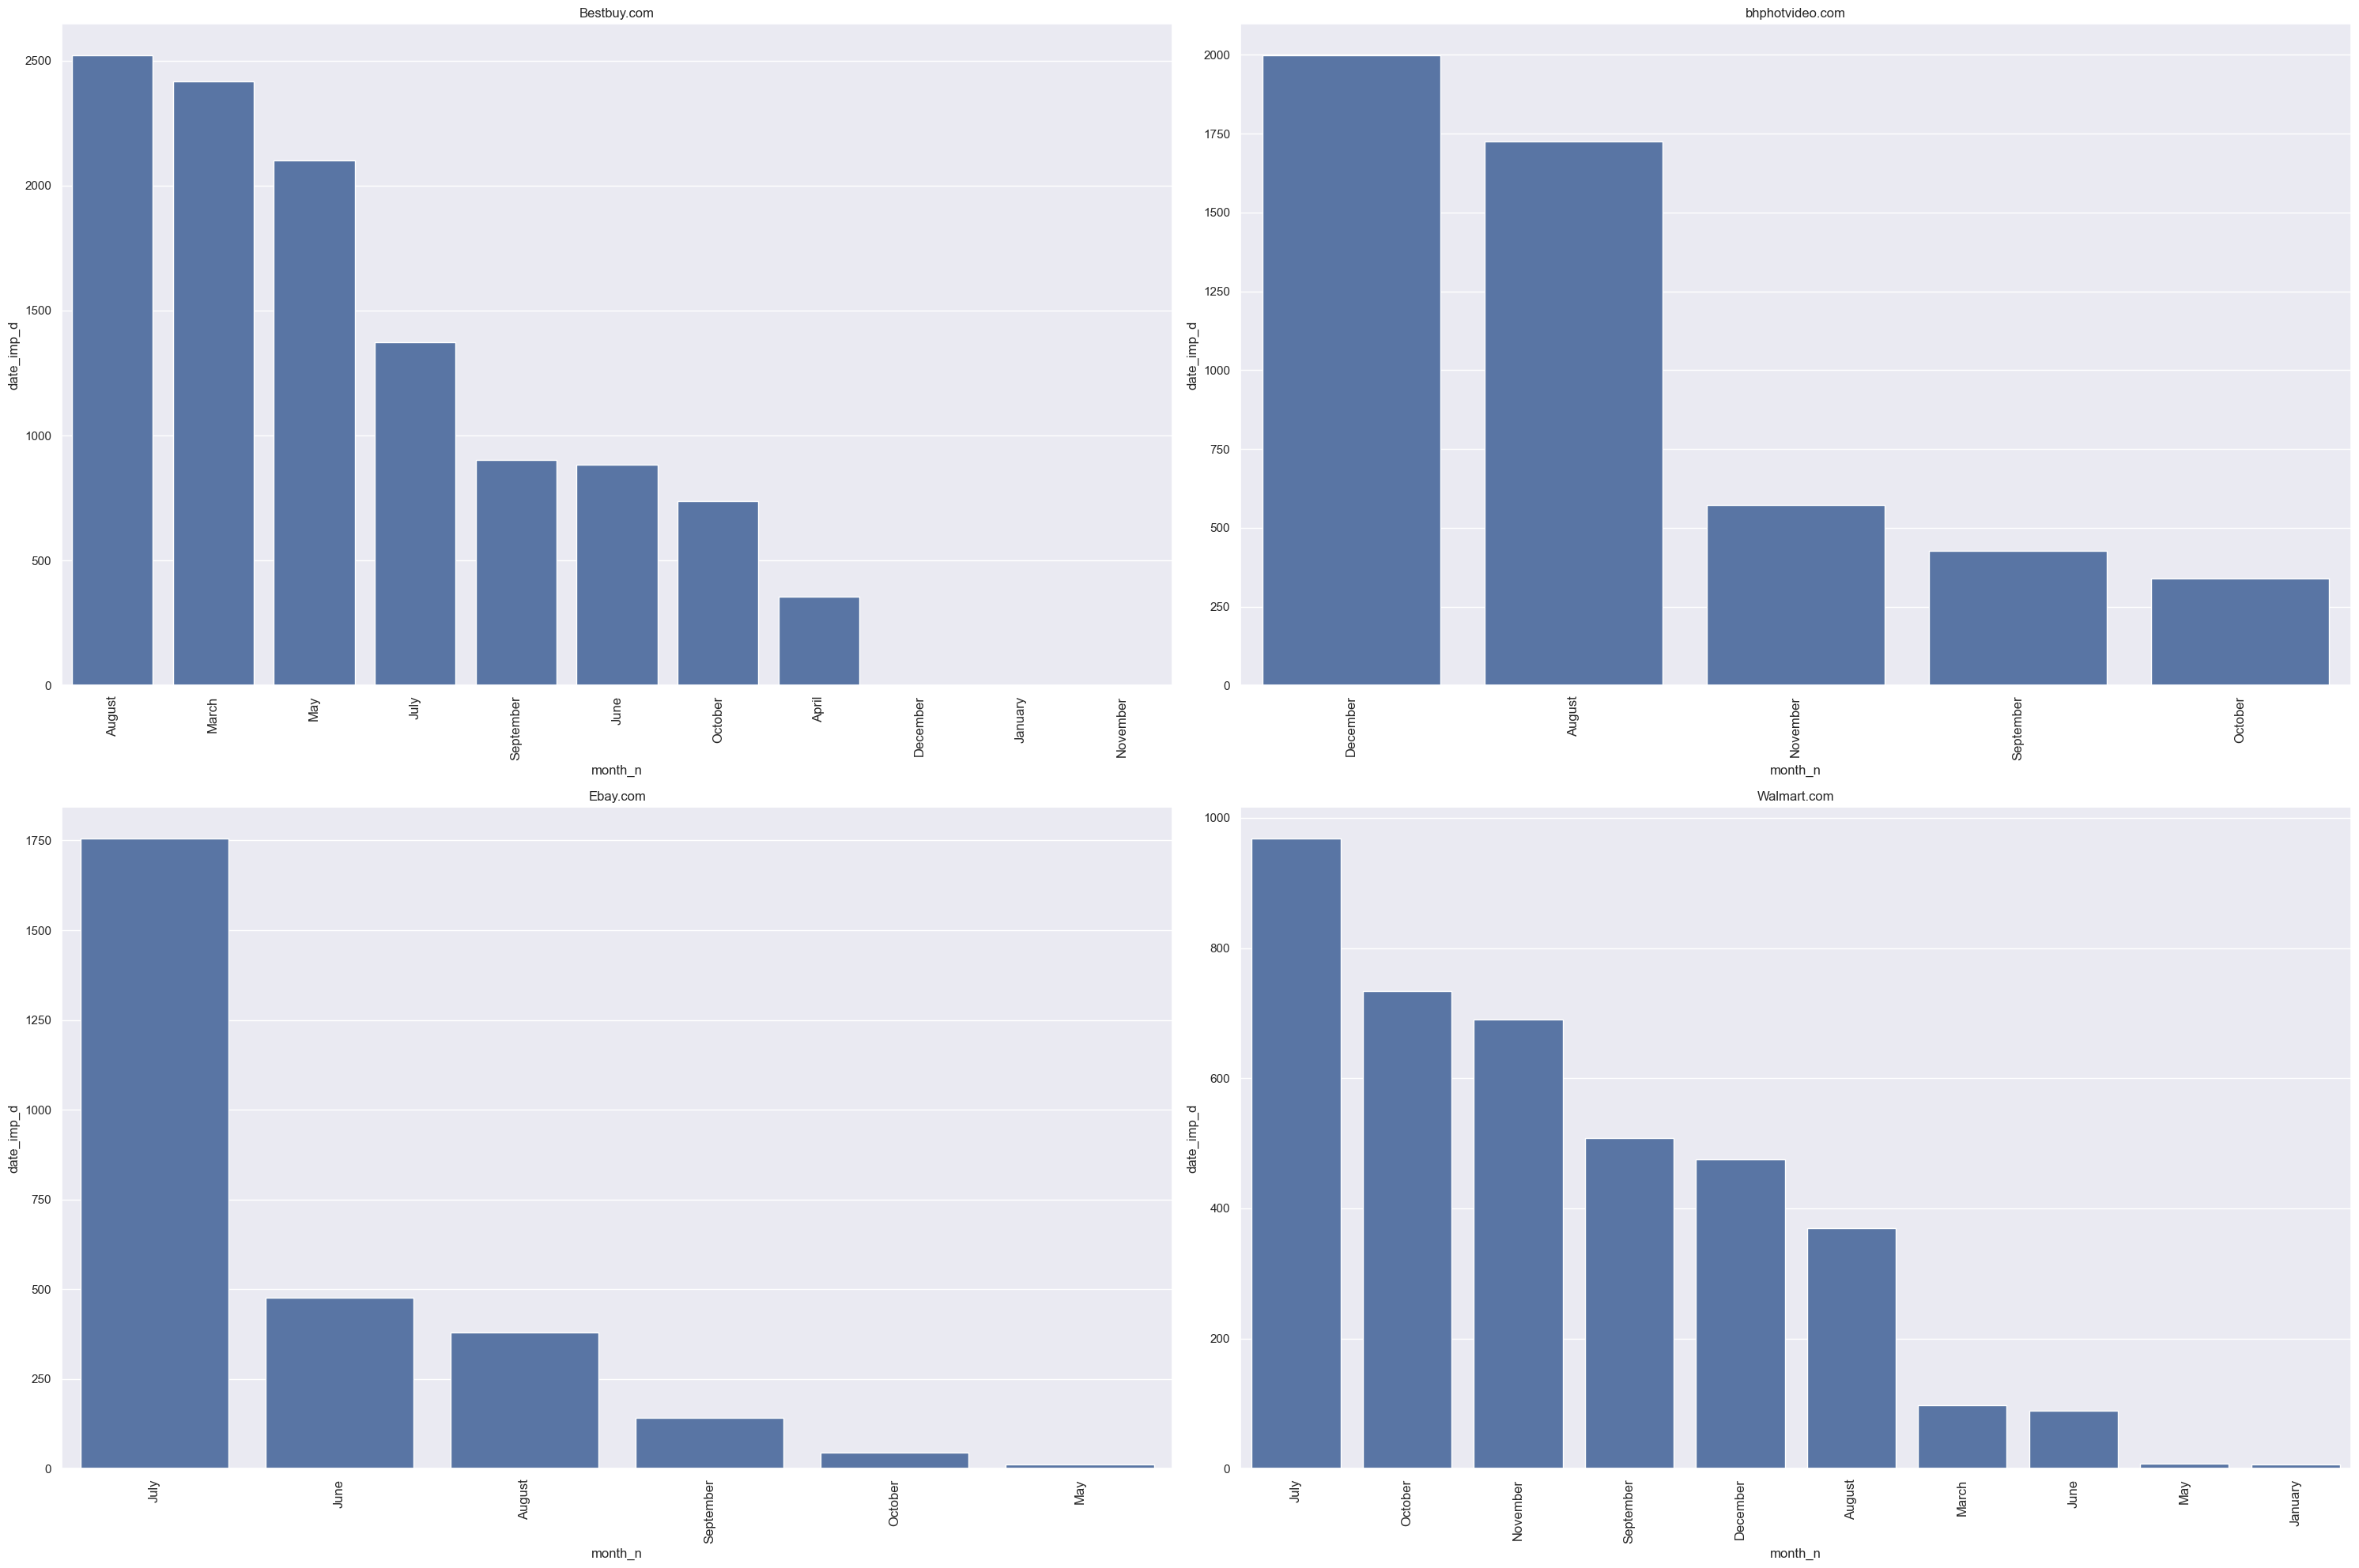

In [28]:
plt.figure(figsize=(30,20))


plt.subplot(2,2,1)
aux18 = df_best[['date_imp_d', 'month_n']].groupby('month_n').count().reset_index().sort_values(by='date_imp_d', ascending=False)
plt.xticks(rotation=90, fontsize=12)
plt.title('Bestbuy.com')
sns.barplot(x='month_n', y='date_imp_d', data=aux18)

plt.subplot(2,2,2)
aux19 = df_bhp[['date_imp_d', 'month_n']].groupby('month_n').count().reset_index().sort_values(by='date_imp_d', ascending=False)
plt.xticks(rotation=90, fontsize=12)
plt.title('bhphotvideo.com')
sns.barplot(x='month_n', y='date_imp_d', data=aux19)

plt.subplot(2,2,3)
aux20 = df_ebay[['date_imp_d', 'month_n']].groupby('month_n').count().reset_index().sort_values(by='date_imp_d', ascending=False)
plt.xticks(rotation=90, fontsize=12)
plt.title('Ebay.com')
sns.barplot(x='month_n', y='date_imp_d', data=aux20)

plt.subplot(2,2,4)
aux21 = df_walmart[['date_imp_d', 'month_n']].groupby('month_n').count().reset_index().sort_values(by='date_imp_d', ascending=False)
plt.xticks(rotation=90, fontsize=12)
plt.title('Walmart.com')
sns.barplot(x='month_n', y='date_imp_d', data=aux21)

plt.tight_layout()

## 2.7. Quais as semanas que mais vendem?

<Axes: xlabel='week_number', ylabel='date_imp_d'>

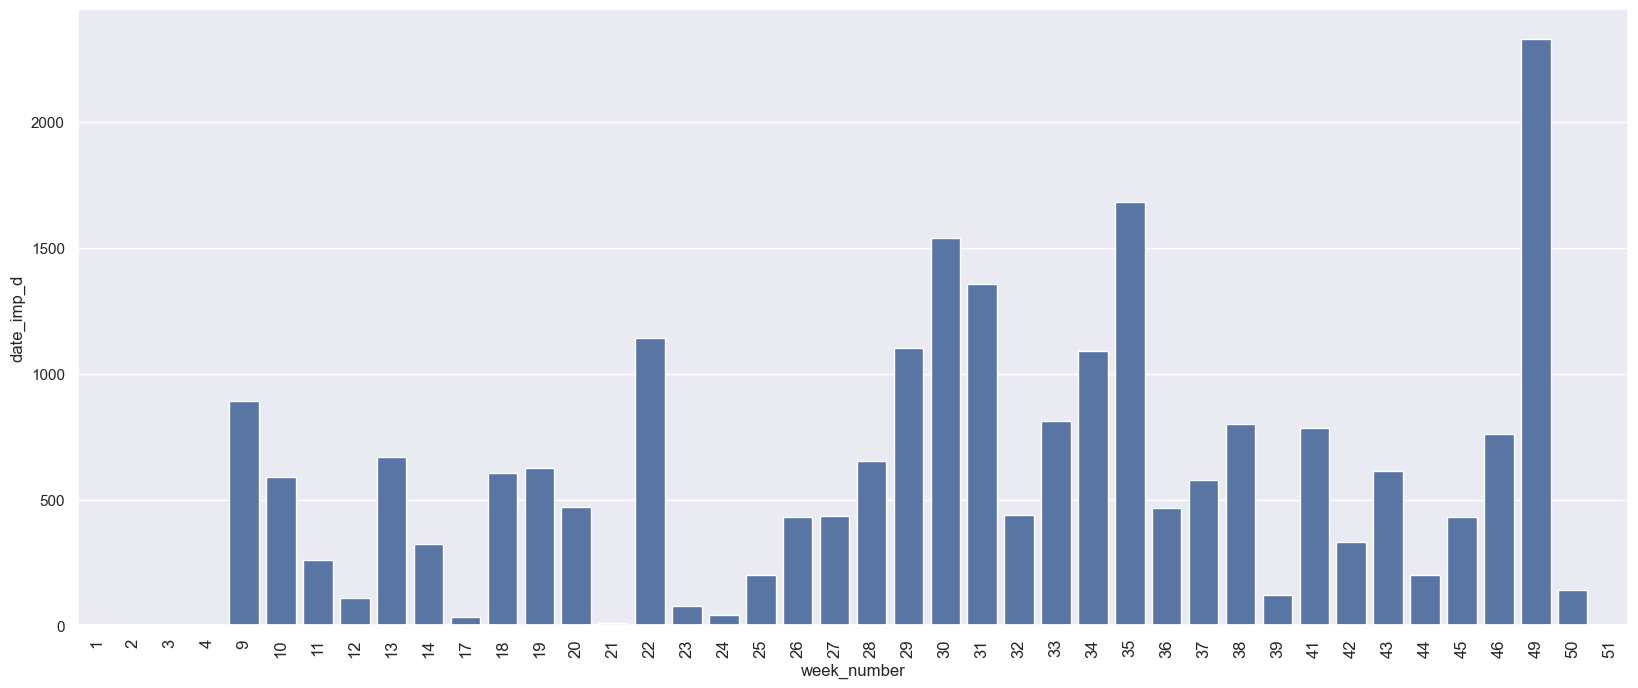

In [29]:
plt.figure(figsize=(20,8))
aux22 = df2[['date_imp_d', 'week_number']].groupby('week_number').count().reset_index().sort_values(by='date_imp_d', ascending=False)
plt.xticks(rotation=90, fontsize=12)
sns.barplot(x='week_number', y='date_imp_d', data=aux22)

## 2.8. Quais os semanas que mais vendem por loja?¶

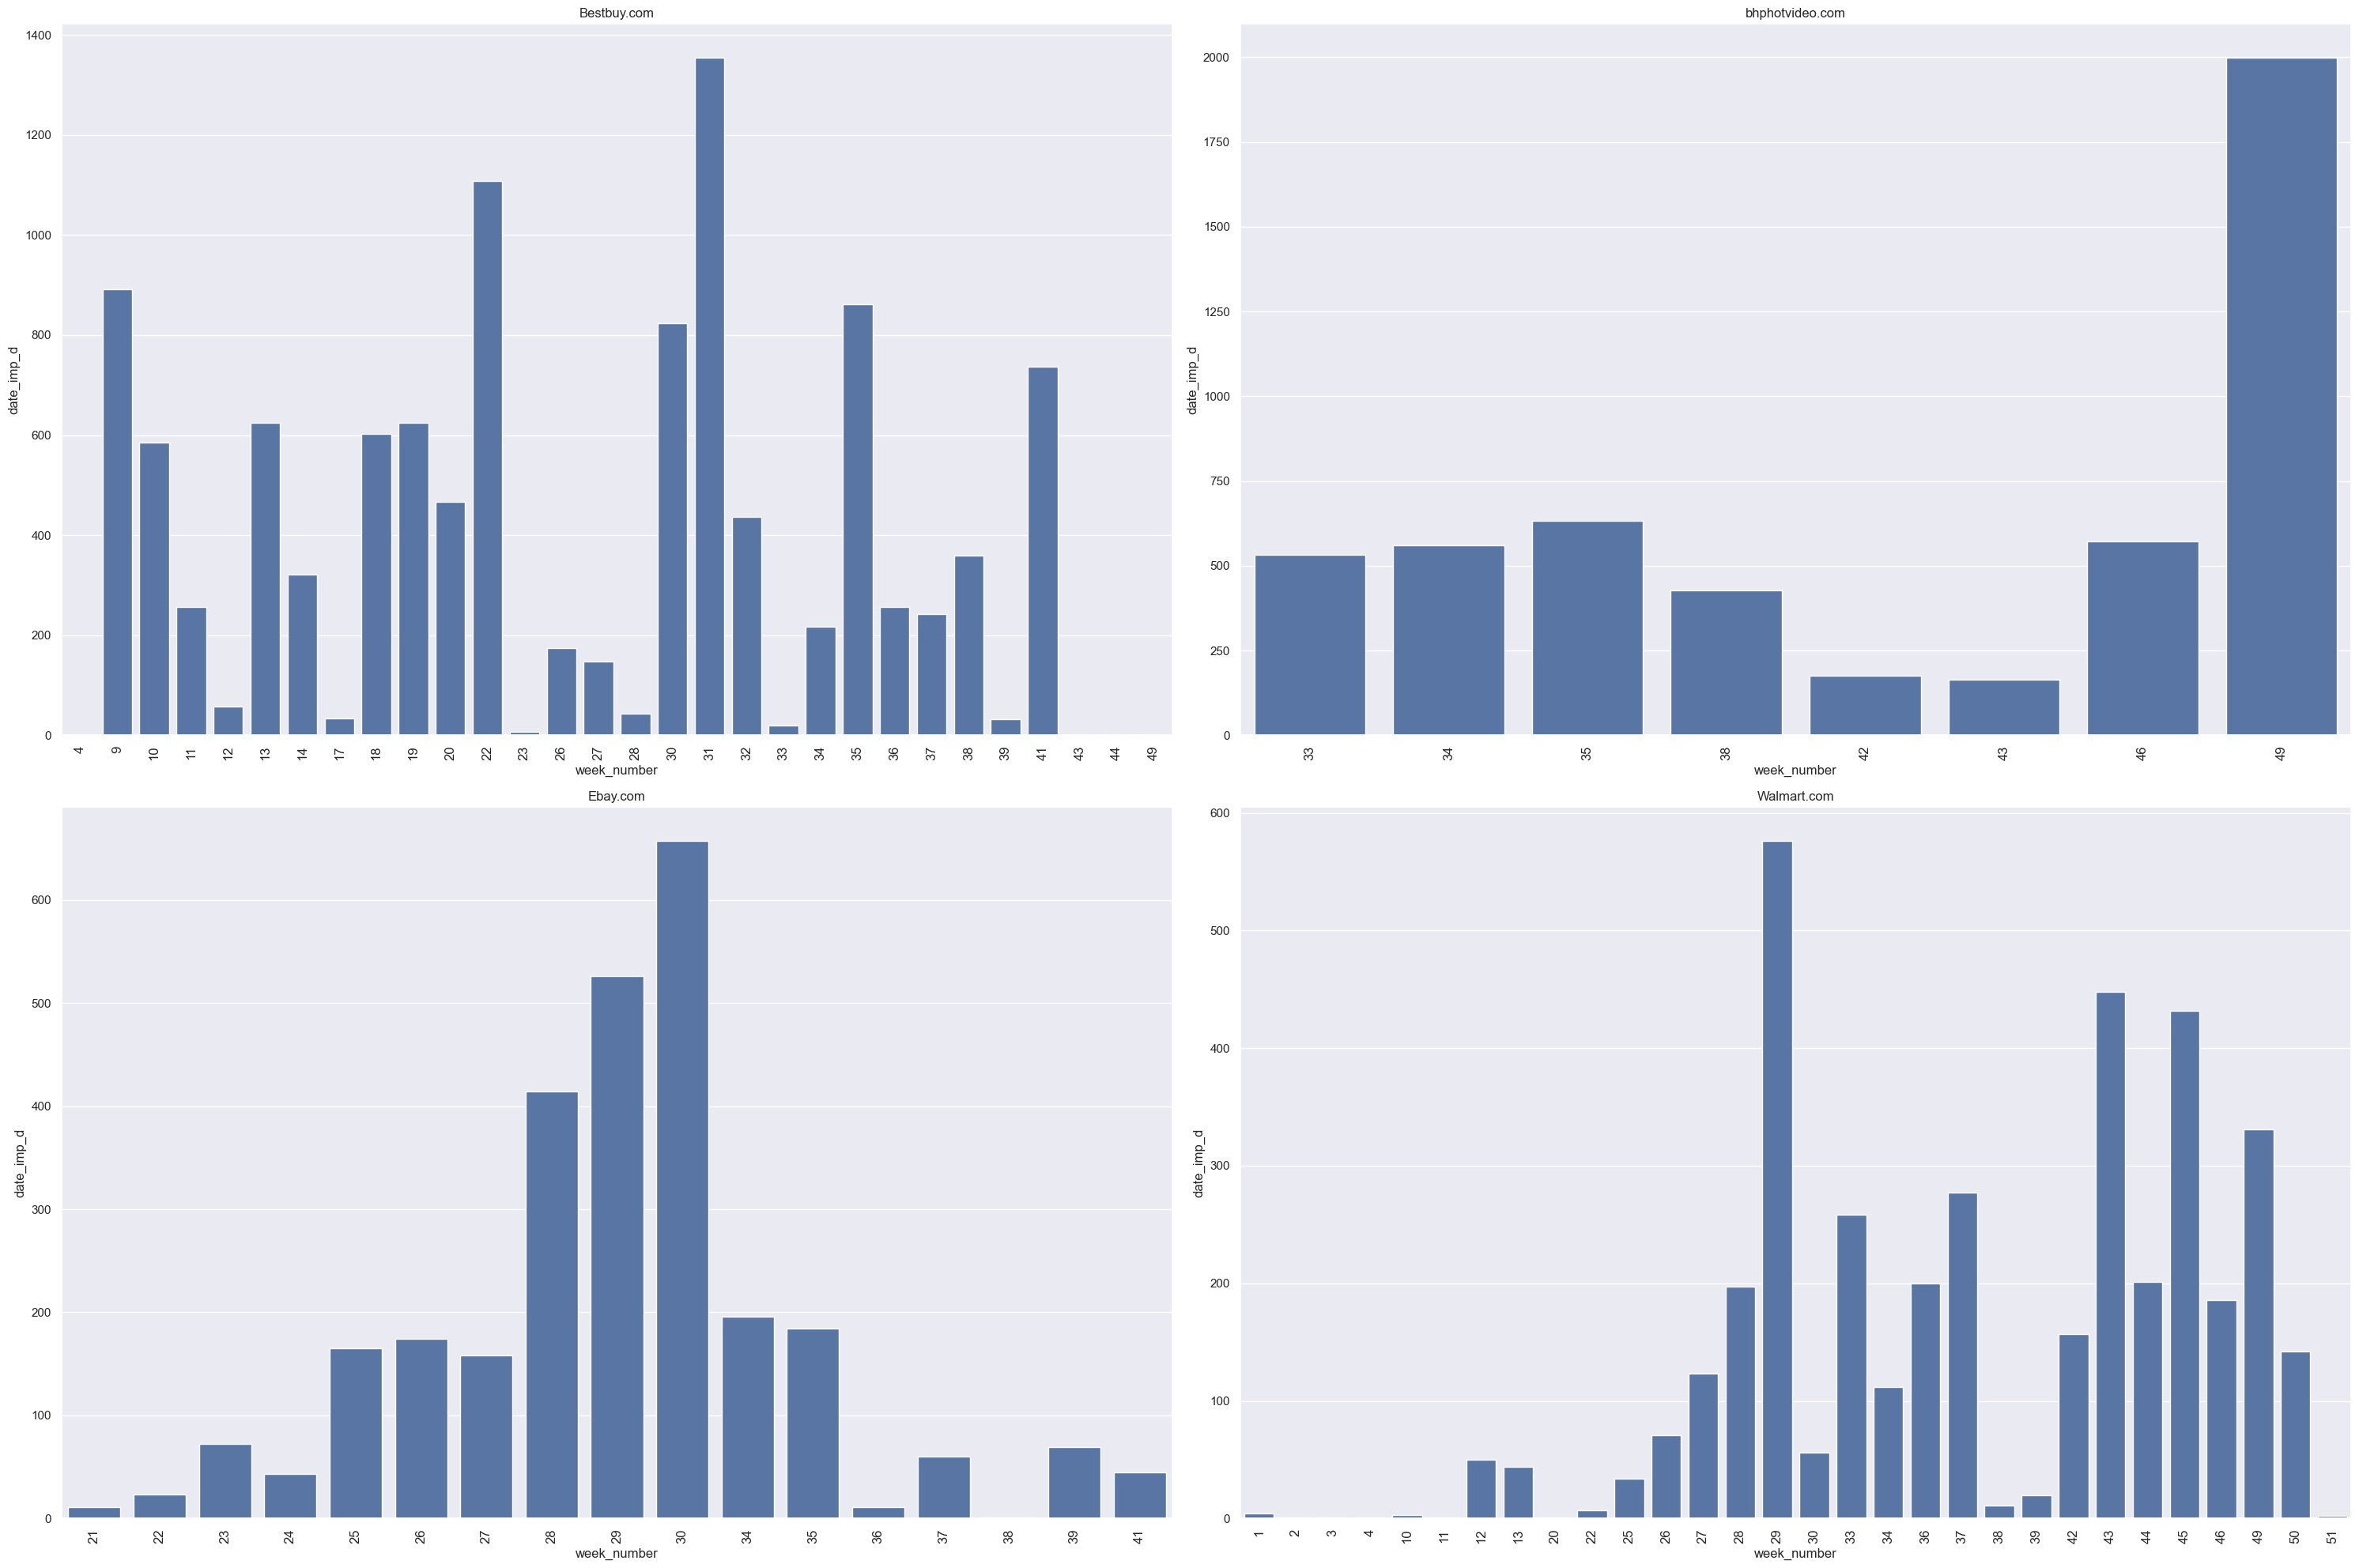

In [30]:
plt.figure(figsize=(30,20))


plt.subplot(2,2,1)
aux23 = df_best[['date_imp_d', 'week_number']].groupby('week_number').count().reset_index().sort_values(by='date_imp_d', ascending=False)
plt.xticks(rotation=90, fontsize=12)
plt.title('Bestbuy.com')
sns.barplot(x='week_number', y='date_imp_d', data=aux23)

plt.subplot(2,2,2)
aux24 = df_bhp[['date_imp_d', 'week_number']].groupby('week_number').count().reset_index().sort_values(by='date_imp_d', ascending=False)
plt.xticks(rotation=90, fontsize=12)
plt.title('bhphotvideo.com')
sns.barplot(x='week_number', y='date_imp_d', data=aux24)

plt.subplot(2,2,3)
aux25 = df_ebay[['date_imp_d', 'week_number']].groupby('week_number').count().reset_index().sort_values(by='date_imp_d', ascending=False)
plt.xticks(rotation=90, fontsize=12)
plt.title('Ebay.com')
sns.barplot(x='week_number', y='date_imp_d', data=aux25)

plt.subplot(2,2,4)
aux26 = df_walmart[['date_imp_d', 'week_number']].groupby('week_number').count().reset_index().sort_values(by='date_imp_d', ascending=False)
plt.xticks(rotation=90, fontsize=12)
plt.title('Walmart.com')
sns.barplot(x='week_number', y='date_imp_d', data=aux26)

plt.tight_layout()

# 3.0 Feature Engineering

In [36]:
df3 = df2.copy()

## 3.1. Categoria mais vendida Bestuy.com

In [37]:
df_best.head()

date_imp_d                 category_name                                               name  price  disc_price     merchant    brand manufacturer      day_n  month  month_n  day  week_number
6  2017-10-10  speaker, portable, bluetooth  Boytone - 2500W 2.1-Ch. Home Theater System - ...  69.99       69.99  Bestbuy.com  Boytone      Boytone    Tuesday     10  October   10           41
7  2017-08-28  speaker, portable, bluetooth  Boytone - 2500W 2.1-Ch. Home Theater System - ...  66.99       66.99  Bestbuy.com  Boytone      Boytone     Monday      8   August   28           35
8  2017-08-12  speaker, portable, bluetooth  Boytone - 2500W 2.1-Ch. Home Theater System - ...  65.99       65.99  Bestbuy.com  Boytone      Boytone   Saturday      8   August   12           32
9  2017-08-01  speaker, portable, bluetooth  Boytone - 2500W 2.1-Ch. Home Theater System - ...  64.99       64.99  Bestbuy.com  Boytone      Boytone    Tuesday      8   August    1           31
10 2017-07-26  speaker, portable, bluetooth  Boytone - 2500W 2.1-Ch. Home Theater System - ...  64.99       64.99  Bestbuy.com  Boytone      Boytone  Wednesday      7     July   26           30

In [38]:
df_laptop = df_best[df_best['category_name'] == 'laptop, computer']

In [39]:
test = df_laptop.groupby(['name','week_number']).agg({'disc_price':'mean', 'date_imp_d':'count'}).reset_index()

In [40]:
x_price = test.pivot(index='week_number', columns='name', values='disc_price')
x_price = pd.DataFrame(x_price.to_records())

In [41]:
x_price.head()

week_number  12 MacBook (Mid 2017, Gold)  12 MacBook (Mid 2017, Silver)  12.3 32GB Multi-Touch 2-in-1 Chromebook Plus  13.3 MacBook Air (Mid 2017, Silver)  15.4 MacBook Pro with Touch Bar (Late 2016, Silver)  15.4 MacBook Pro with Touch Bar (Late 2016, Space Gray)  ASUS VivoBook Max X541SA 15.6Inch Laptop Intel Pentium 4GB Memory 500GB HD Matte IMR X541SA-PD0703X  Acer - 2-in-1 15.6 Refurbished Touch-Screen Laptop - Intel Core i7 - 12GB Memory - NVIDIA GeForce 940MX - 1TB Hard Drive - Steel gray"  Acer 15.6 Chromebook CB5-571-C4G4  Alienware - R3 17.3 Laptop - Intel Core i7 - 16GB Memory - 1TB Hard Drive + 256GB Solid State Drive - Epic Silver"  Apple - MacBook Pro® - 13 Display - Intel Core i5 - 8 GB Memory - 256GB Flash Storage (Latest Model) - Silver"  Apple - MacBook Pro® - 13 Display - Intel Core i5 - 8 GB Memory - 256GB Flash Storage (Latest Model) - Space Gray"  Apple - MacBook Pro® - 13 Display - Intel Core i5 - 8 GB Memory - 512GB Flash Storage (Latest Model) - Silver"  Apple 13.3 MacBook Air ( Silver)"  Apple MacBook - 12 - Core m5 - 8 GB RAM - 512 GB flash storage - English"  Apple MacBook Pro MLUQ2LL/A 13.3 Notebook - Intel Core i5 Dual-core (2 Core) 2 GHz - 8 GB LPDDR3 - 256 GB SSD - Mac OS X 10.12 Sierra - 2560 x 1600 - In-plane Switching (IPS) Technology - Silver"  Apple MacBook Pro with Touch Bar - 13.3 - Core i5 - 8 GB RAM - 512 GB SSD - English"  Asus - 2-in-1 15.6 4K Ultra HD Touch-Screen Laptop Intel Core i7 16GB Memory NVIDIA GeForce GTX 950M - 2TB HDD + 512GB SSD - Sandblasted matte black aluminum"  Dell - Inspiron 15.6 Laptop - Intel Core i5 - 8GB Memory - NVIDIA GeForce GTX 1050 - 1TB + 8GB Hybrid Hard Drive - Red"  Dell - XPS 2-in-1 13.3 Touch-Screen Laptop - Intel Core i7 - 16GB Memory - 256GB Solid State Drive - Silver"  Dell XPS 15 15.6 4K Touchcreen Laptop Intel i7-6700HQ 16GB 1TB SSD GTX 960M"  Details About Alienware 13 R3 Aw13r3/13.3 Fhd/i77700hq/nvidia Gtx 1060/16gb/512gb Ssd"  Details About Alienware 15 R3 Aw15r3/15.6 Fhd/i77700hq/nvidia Gtx1070/16gb/1tb Hdd+128gb Ssd"  Details About Apple Macbook Air 13.3 Laptop (early 2015) 2.2ghz Core I7 8gb 256gb"  Details About Asus Q304 13.3 Laptop I5 2.5 Ghz 6gb 1tb Hdd Win 10 (q304uabhi5t11)"  Details About Dell Inspiron I75675650blkpus 15.6 Laptop I57300hq"  Details About Openbox Excellent: Asus Rog Gl502vm 15.6 Laptop Intel Core I7 12gb Me..."  Details About Razer Blade Laptop 14 Full Hd (i77700hq"  Ginsu BESTBUY5580020 Lenovo Ideapad 11.6 Laptop"  HP - ProBook 14 Laptop - Intel Core i5 - 4GB Memory - 500GB Hard Drive - Black"  HP 15-AY103DX 15.6 Touchscreen Touch Screen HD Laptop Notebook PC Computer 7th Gen i5-7200U Kaby Lake 8GB Memory 1TB HDD Hard Drive Windows 10"  Lenovo - 100S-14IBR 14 Laptop - Intel Celeron - 2GB Memory - 32GB eMMC Flash Memory - Navy blue"  Lenovo - Yoga 710 2-in-1 11.6 Touch-Screen Laptop - Intel Core i5 - 8GB Memory - 128GB Solid State Drive - Silver Tablet PC Notebook 80V6000PUS"  Lenovo 80TX0007US Y 710-11ISK 11.6-Inch FHD Touch Laptop (Pentium 4405Y, 4 GB Ram, 128 GB SSD, Windows 10), SilverNotebook PC Computer Tablet Touchscreen Screen 2-in-1  Lenovo Flex 4 1470 80SA0000US 2-in-1 - 14 HD Touch - Pentium 4405U 2.1Ghz - 4GB - 500GB"  MSI - WS Series 15.6 Laptop - Intel Core i7 - 16GB Memory - 256GB Solid State Drive + 2TB Hard Drive - Aluminum Black"  New Asus Q524u 15.6fhd 2in1 Touch I77500u 3.5ghz 16gb Ddr4 2tb Hd 940mx2gb W10"  Razer - Blade Pro 17.3 4K Ultra HD Touch-Screen Laptop - Intel Core i7 - 32GB Memory - NVIDIA GeForce GTX 1080 - 1TB SSD - Black"  Samsung - Notebook 5 15.6 Touch-Screen Laptop - Intel Core i5 - 8GB Memory - NVIDIA GeForce 920MX - 1TB Hard Drive - Solid black"
0            4                          NaN                            NaN                                           NaN                                  NaN                                                NaN                                                  NaN                                                      NaN                      

In [42]:
y_demand = test.pivot(index='week_number', columns='name', values='date_imp_d')
y_demand = pd.DataFrame(y_demand.to_records())

# 4.0. Description of the dataframe

## 4.1. Description of the data

###    4.1.1 Data Dimension

In [43]:
print('Number of Rows: {}'.format(x_price.shape[0]))
print('Number of columns {}'.format(x_price.shape[1]))

Number of Rows: 26
Number of columns 40


In [44]:
print('Number of Rows: {}'.format(y_demand.shape[0]))
print('Number of columns {}'.format(y_demand.shape[1]))

Number of Rows: 26
Number of columns 40


## 4.2. Data Types

In [45]:
#x_price.dtypes

In [46]:
#y_demand.dtypes

## 4.5. Replace NA

In [47]:
a = np.round(x_price.median(),2)
x_price.fillna(a, inplace=True)
x_price.head()

week_number  12 MacBook (Mid 2017, Gold)  12 MacBook (Mid 2017, Silver)  12.3 32GB Multi-Touch 2-in-1 Chromebook Plus  13.3 MacBook Air (Mid 2017, Silver)  15.4 MacBook Pro with Touch Bar (Late 2016, Silver)  15.4 MacBook Pro with Touch Bar (Late 2016, Space Gray)  ASUS VivoBook Max X541SA 15.6Inch Laptop Intel Pentium 4GB Memory 500GB HD Matte IMR X541SA-PD0703X  Acer - 2-in-1 15.6 Refurbished Touch-Screen Laptop - Intel Core i7 - 12GB Memory - NVIDIA GeForce 940MX - 1TB Hard Drive - Steel gray"  Acer 15.6 Chromebook CB5-571-C4G4  Alienware - R3 17.3 Laptop - Intel Core i7 - 16GB Memory - 1TB Hard Drive + 256GB Solid State Drive - Epic Silver"  Apple - MacBook Pro® - 13 Display - Intel Core i5 - 8 GB Memory - 256GB Flash Storage (Latest Model) - Silver"  Apple - MacBook Pro® - 13 Display - Intel Core i5 - 8 GB Memory - 256GB Flash Storage (Latest Model) - Space Gray"  Apple - MacBook Pro® - 13 Display - Intel Core i5 - 8 GB Memory - 512GB Flash Storage (Latest Model) - Silver"  Apple 13.3 MacBook Air ( Silver)"  Apple MacBook - 12 - Core m5 - 8 GB RAM - 512 GB flash storage - English"  Apple MacBook Pro MLUQ2LL/A 13.3 Notebook - Intel Core i5 Dual-core (2 Core) 2 GHz - 8 GB LPDDR3 - 256 GB SSD - Mac OS X 10.12 Sierra - 2560 x 1600 - In-plane Switching (IPS) Technology - Silver"  Apple MacBook Pro with Touch Bar - 13.3 - Core i5 - 8 GB RAM - 512 GB SSD - English"  Asus - 2-in-1 15.6 4K Ultra HD Touch-Screen Laptop Intel Core i7 16GB Memory NVIDIA GeForce GTX 950M - 2TB HDD + 512GB SSD - Sandblasted matte black aluminum"  Dell - Inspiron 15.6 Laptop - Intel Core i5 - 8GB Memory - NVIDIA GeForce GTX 1050 - 1TB + 8GB Hybrid Hard Drive - Red"  Dell - XPS 2-in-1 13.3 Touch-Screen Laptop - Intel Core i7 - 16GB Memory - 256GB Solid State Drive - Silver"  Dell XPS 15 15.6 4K Touchcreen Laptop Intel i7-6700HQ 16GB 1TB SSD GTX 960M"  Details About Alienware 13 R3 Aw13r3/13.3 Fhd/i77700hq/nvidia Gtx 1060/16gb/512gb Ssd"  Details About Alienware 15 R3 Aw15r3/15.6 Fhd/i77700hq/nvidia Gtx1070/16gb/1tb Hdd+128gb Ssd"  Details About Apple Macbook Air 13.3 Laptop (early 2015) 2.2ghz Core I7 8gb 256gb"  Details About Asus Q304 13.3 Laptop I5 2.5 Ghz 6gb 1tb Hdd Win 10 (q304uabhi5t11)"  Details About Dell Inspiron I75675650blkpus 15.6 Laptop I57300hq"  Details About Openbox Excellent: Asus Rog Gl502vm 15.6 Laptop Intel Core I7 12gb Me..."  Details About Razer Blade Laptop 14 Full Hd (i77700hq"  Ginsu BESTBUY5580020 Lenovo Ideapad 11.6 Laptop"  HP - ProBook 14 Laptop - Intel Core i5 - 4GB Memory - 500GB Hard Drive - Black"  HP 15-AY103DX 15.6 Touchscreen Touch Screen HD Laptop Notebook PC Computer 7th Gen i5-7200U Kaby Lake 8GB Memory 1TB HDD Hard Drive Windows 10"  Lenovo - 100S-14IBR 14 Laptop - Intel Celeron - 2GB Memory - 32GB eMMC Flash Memory - Navy blue"  Lenovo - Yoga 710 2-in-1 11.6 Touch-Screen Laptop - Intel Core i5 - 8GB Memory - 128GB Solid State Drive - Silver Tablet PC Notebook 80V6000PUS"  Lenovo 80TX0007US Y 710-11ISK 11.6-Inch FHD Touch Laptop (Pentium 4405Y, 4 GB Ram, 128 GB SSD, Windows 10), SilverNotebook PC Computer Tablet Touchscreen Screen 2-in-1  Lenovo Flex 4 1470 80SA0000US 2-in-1 - 14 HD Touch - Pentium 4405U 2.1Ghz - 4GB - 500GB"  MSI - WS Series 15.6 Laptop - Intel Core i7 - 16GB Memory - 256GB Solid State Drive + 2TB Hard Drive - Aluminum Black"  New Asus Q524u 15.6fhd 2in1 Touch I77500u 3.5ghz 16gb Ddr4 2tb Hd 940mx2gb W10"  Razer - Blade Pro 17.3 4K Ultra HD Touch-Screen Laptop - Intel Core i7 - 32GB Memory - NVIDIA GeForce GTX 1080 - 1TB SSD - Black"  Samsung - Notebook 5 15.6 Touch-Screen Laptop - Intel Core i5 - 8GB Memory - NVIDIA GeForce 920MX - 1TB Hard Drive - Solid black"
0            4                      1551.99                        1299.99                                       415.500                               949.99                                            2618.99                                              2353.99                                                   304.99                      

In [48]:
y_demand.fillna(0, inplace=True)

# EDA

<Axes: xlabel='products', ylabel='demand'>

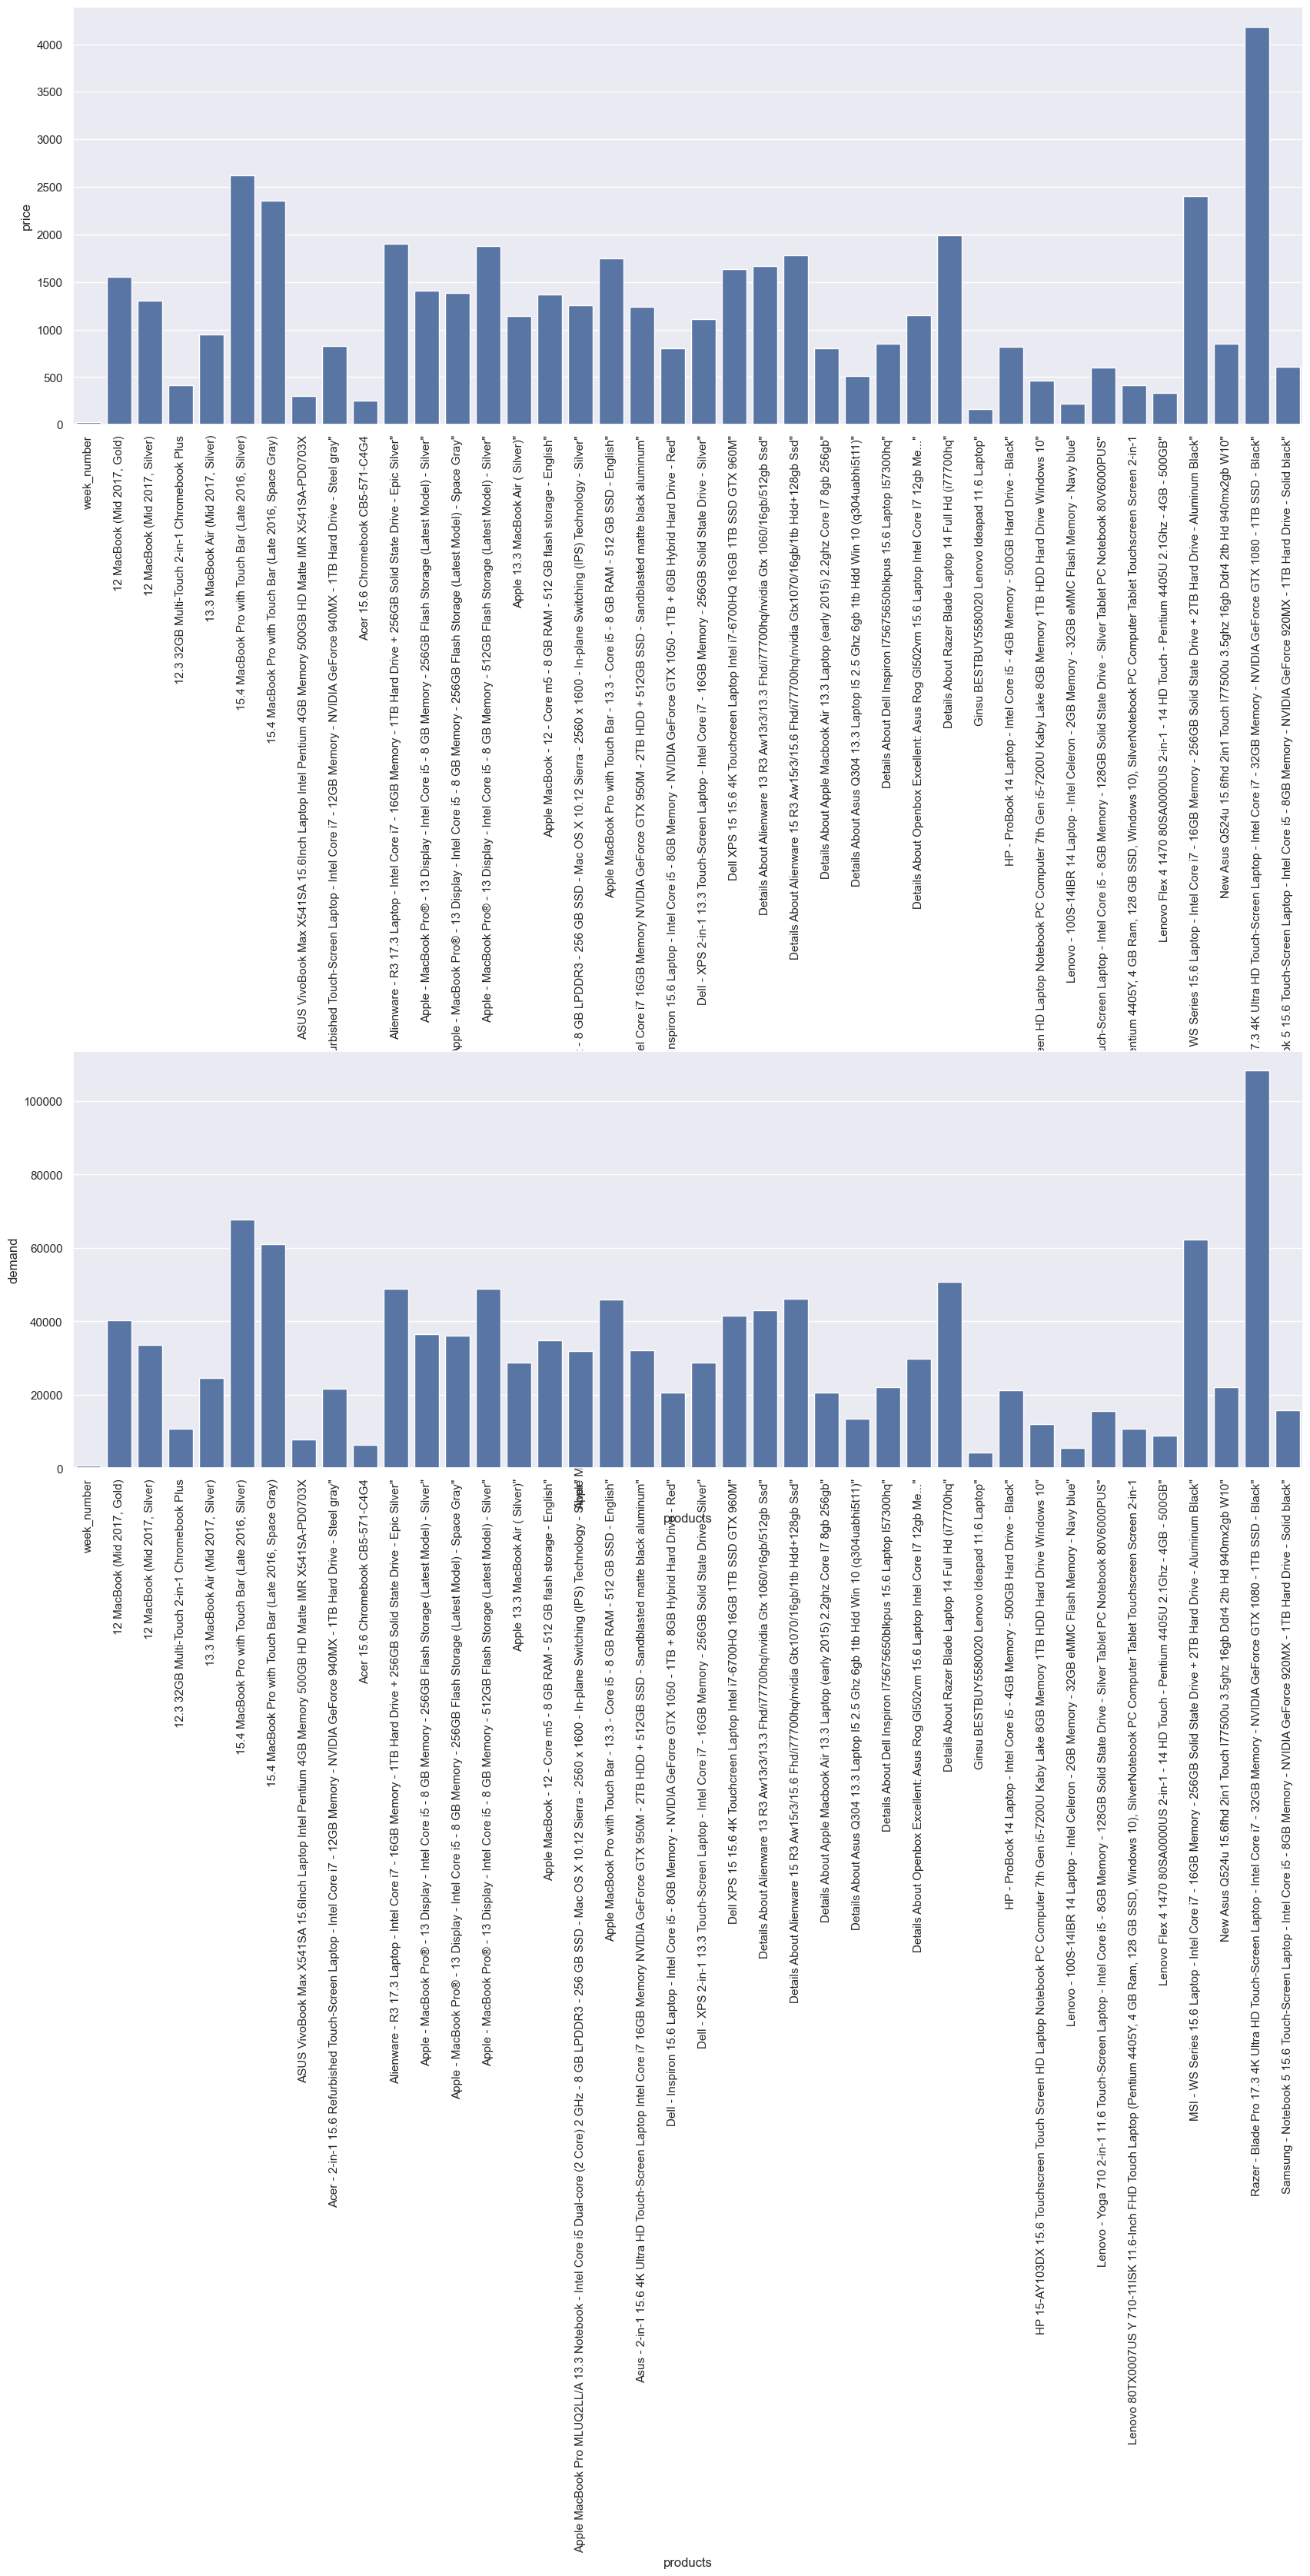

In [44]:
plt.figure(figsize=(20,10))

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=2, hspace=1.5)

plt.subplot(2, 1, 1)
aux1 = pd.DataFrame(x_price.apply( lambda x: x.median())).reset_index()
aux1.columns = ['products', 'price']
plt.xticks(rotation=90)
sns.barplot(x='products', y='price', data=aux1)


plt.subplot(2, 1, 2)
aux2 = pd.DataFrame(x_price.apply( lambda x: x.sum())).reset_index()
aux2.columns = ['products', 'demand']
plt.xticks(rotation=90)
sns.barplot(x='products', y='demand', data=aux2)




In [49]:
a = ['week_number', '12 MacBook (Mid 2017, Gold)',
       '12 MacBook (Mid 2017, Silver)',
       '12.3 32GB Multi-Touch 2-in-1 Chromebook Plus',
       '13.3 MacBook Air (Mid 2017, Silver)',
       '15.4 MacBook Pro with Touch Bar (Late 2016, Silver)',
       '15.4 MacBook Pro with Touch Bar (Late 2016, Space Gray)',
       'ASUS VivoBook Max X541SA 15.6Inch Laptop Intel Pentium 4GB Memory 500GB HD Matte IMR X541SA-PD0703X',
       'Acer - 2-in-1 15.6 Refurbished Touch-Screen Laptop - Intel Core i7 - 12GB Memory - NVIDIA GeForce 940MX - 1TB Hard Drive - Steel gray"',
       'Acer 15.6 Chromebook CB5-571-C4G4',
       'Alienware - R3 17.3 Laptop - Intel Core i7 - 16GB Memory - 1TB Hard Drive + 256GB Solid State Drive - Epic Silver"',
       'Apple - MacBook Pro® - 13 Display - Intel Core i5 - 8 GB Memory - 256GB Flash Storage (Latest Model) - Silver"',
       'Apple - MacBook Pro® - 13 Display - Intel Core i5 - 8 GB Memory - 256GB Flash Storage (Latest Model) - Space Gray"',
       'Apple - MacBook Pro® - 13 Display - Intel Core i5 - 8 GB Memory - 512GB Flash Storage (Latest Model) - Silver"',
       'Apple 13.3 MacBook Air ( Silver)"',
       'Apple MacBook - 12 - Core m5 - 8 GB RAM - 512 GB flash storage - English"',
       'Apple MacBook Pro MLUQ2LL/A 13.3 Notebook - Intel Core i5 Dual-core (2 Core) 2 GHz - 8 GB LPDDR3 - 256 GB SSD - Mac OS X 10.12 Sierra - 2560 x 1600 - In-plane Switching (IPS) Technology - Silver"',
       'Apple MacBook Pro with Touch Bar - 13.3 - Core i5 - 8 GB RAM - 512 GB SSD - English"',
       'Asus - 2-in-1 15.6 4K Ultra HD Touch-Screen Laptop Intel Core i7 16GB Memory NVIDIA GeForce GTX 950M - 2TB HDD + 512GB SSD - Sandblasted matte black aluminum"',
       'Dell - Inspiron 15.6 Laptop - Intel Core i5 - 8GB Memory - NVIDIA GeForce GTX 1050 - 1TB + 8GB Hybrid Hard Drive - Red"',
       'Dell - XPS 2-in-1 13.3 Touch-Screen Laptop - Intel Core i7 - 16GB Memory - 256GB Solid State Drive - Silver"',
       'Dell XPS 15 15.6 4K Touchcreen Laptop Intel i7-6700HQ 16GB 1TB SSD GTX 960M"',
       'Details About Alienware 13 R3 Aw13r3/13.3 Fhd/i77700hq/nvidia Gtx 1060/16gb/512gb Ssd"',
       'Details About Alienware 15 R3 Aw15r3/15.6 Fhd/i77700hq/nvidia Gtx1070/16gb/1tb Hdd+128gb Ssd"',
       'Details About Apple Macbook Air 13.3 Laptop (early 2015) 2.2ghz Core I7 8gb 256gb"',
       'Details About Asus Q304 13.3 Laptop I5 2.5 Ghz 6gb 1tb Hdd Win 10 (q304uabhi5t11)"',
       'Details About Dell Inspiron I75675650blkpus 15.6 Laptop I57300hq"',
       'Details About Openbox Excellent: Asus Rog Gl502vm 15.6 Laptop Intel Core I7 12gb Me..."',
       'Details About Razer Blade Laptop 14 Full Hd (i77700hq"',
       'Ginsu BESTBUY5580020 Lenovo Ideapad 11.6 Laptop"',
       'HP - ProBook 14 Laptop - Intel Core i5 - 4GB Memory - 500GB Hard Drive - Black"',
       'HP 15-AY103DX 15.6 Touchscreen Touch Screen HD Laptop Notebook PC Computer 7th Gen i5-7200U Kaby Lake 8GB Memory 1TB HDD Hard Drive Windows 10"',
       'Lenovo - 100S-14IBR 14 Laptop - Intel Celeron - 2GB Memory - 32GB eMMC Flash Memory - Navy blue"',
       'Lenovo - Yoga 710 2-in-1 11.6 Touch-Screen Laptop - Intel Core i5 - 8GB Memory - 128GB Solid State Drive - Silver Tablet PC Notebook 80V6000PUS"',
       'Lenovo 80TX0007US Y 710-11ISK 11.6-Inch FHD Touch Laptop (Pentium 4405Y, 4 GB Ram, 128 GB SSD, Windows 10), SilverNotebook PC Computer Tablet Touchscreen Screen 2-in-1',
       'Lenovo Flex 4 1470 80SA0000US 2-in-1 - 14 HD Touch - Pentium 4405U 2.1Ghz - 4GB - 500GB"',
       'MSI - WS Series 15.6 Laptop - Intel Core i7 - 16GB Memory - 256GB Solid State Drive + 2TB Hard Drive - Aluminum Black"',
       'New Asus Q524u 15.6fhd 2in1 Touch I77500u 3.5ghz 16gb Ddr4 2tb Hd 940mx2gb W10"',
       'Razer - Blade Pro 17.3 4K Ultra HD Touch-Screen Laptop - Intel Core i7 - 32GB Memory - NVIDIA GeForce GTX 1080 - 1TB SSD - Black"',
       'Samsung - Notebook 5 15.6 Touch-Screen Laptop - Intel Core i5 - 8GB Memory - NVIDIA GeForce 920MX - 1TB Hard Drive - Solid black"']

In [46]:
plt.close('all')

C:\Users\nerod\AppData\Local\Temp\ipykernel_6720\4060092534.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(20,50))


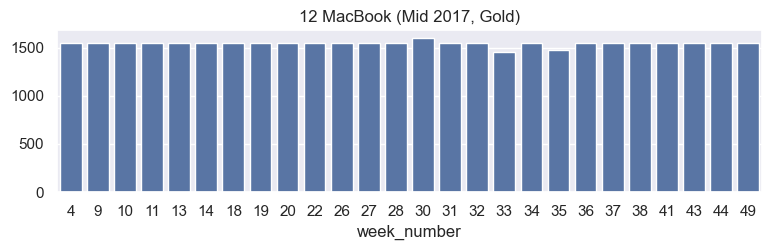

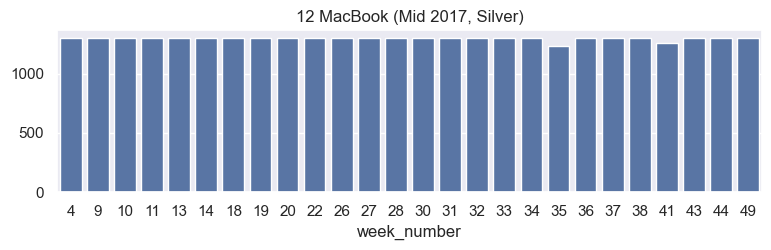

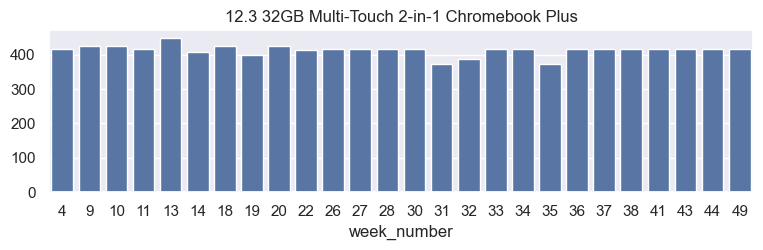

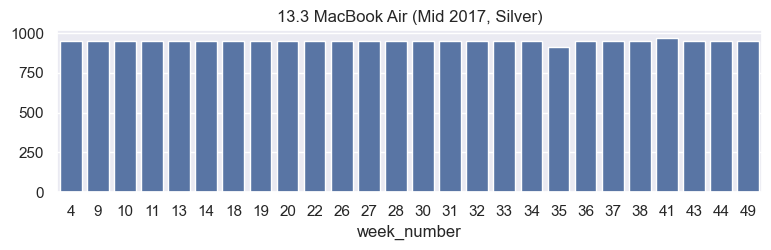

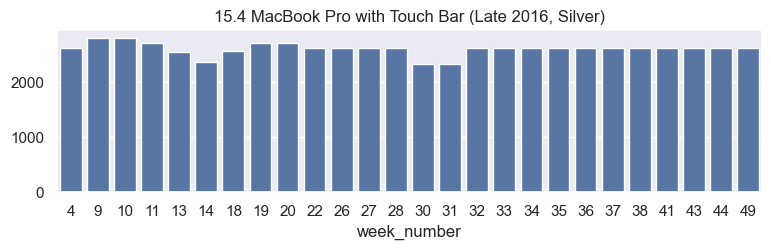

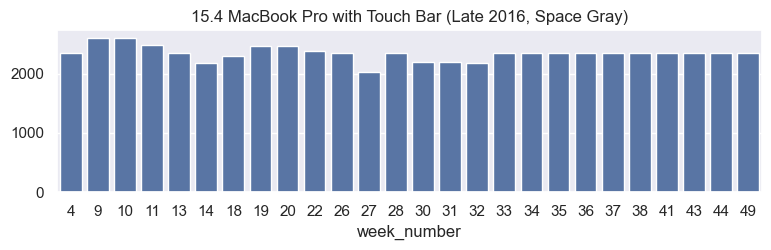

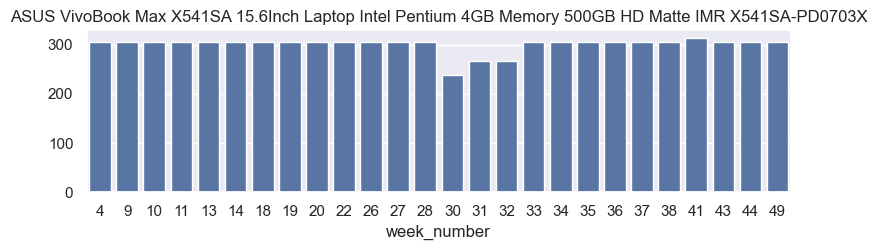

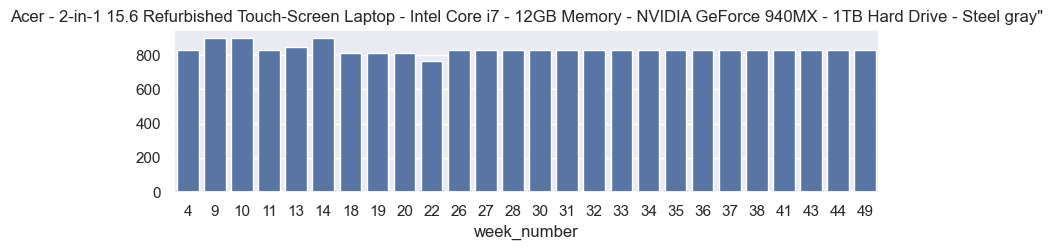

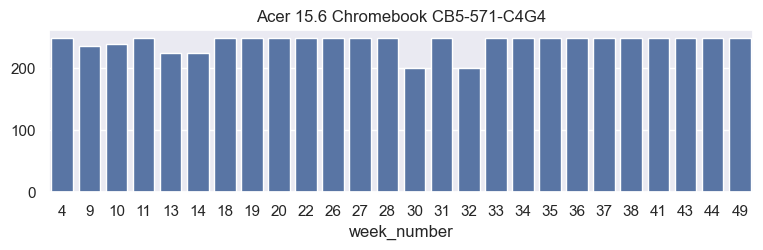

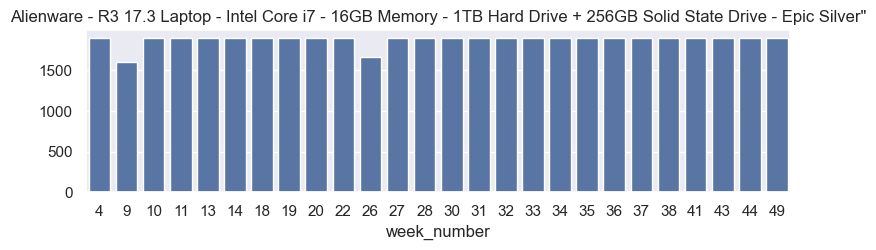

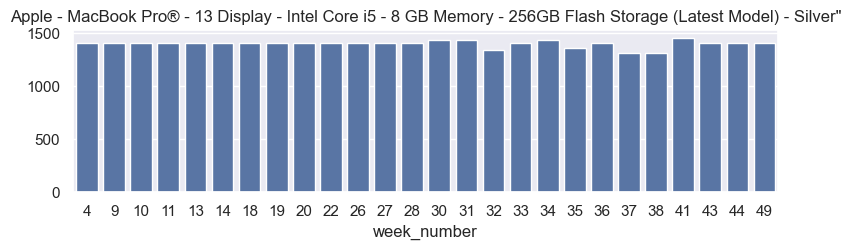

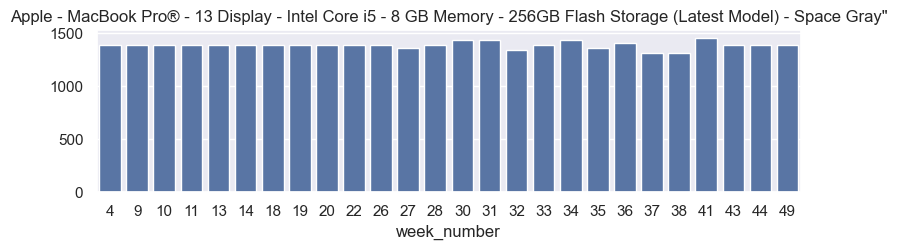

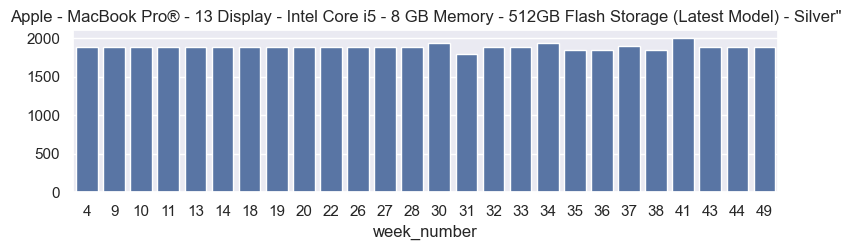

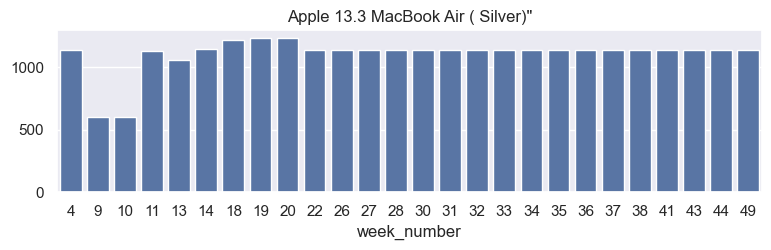

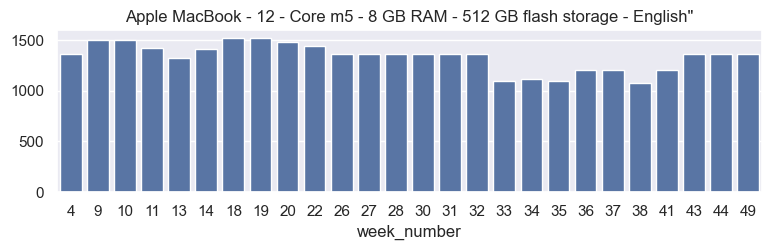

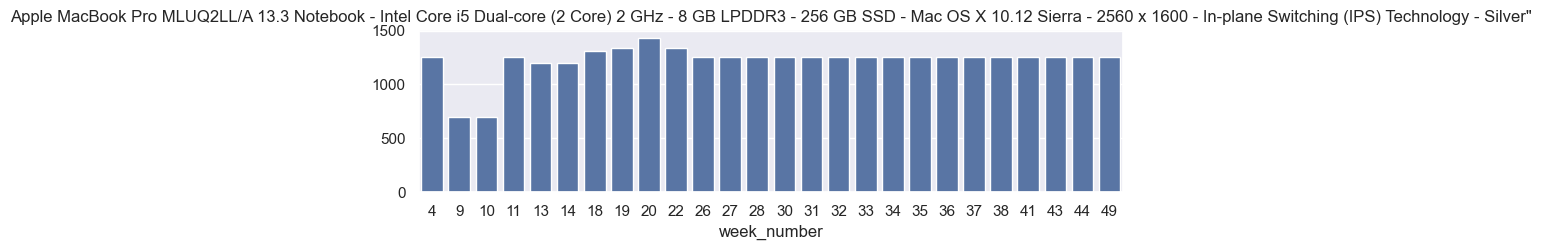

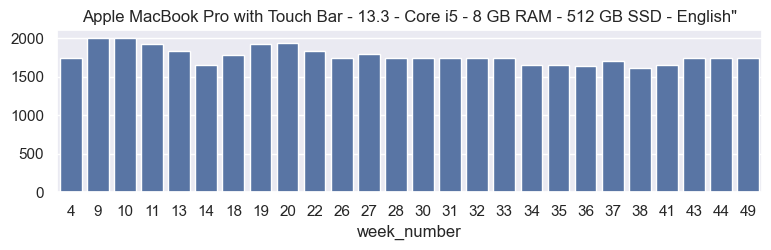

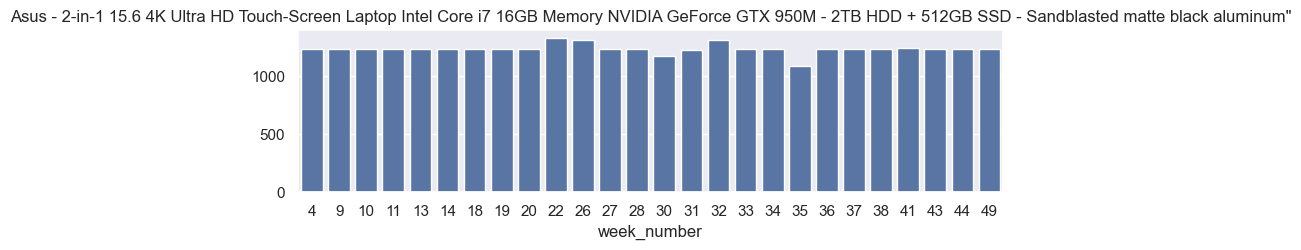

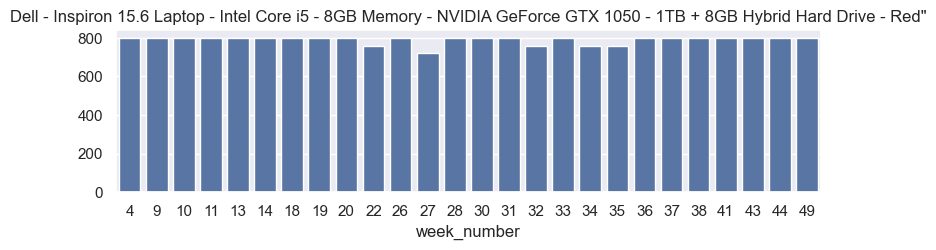

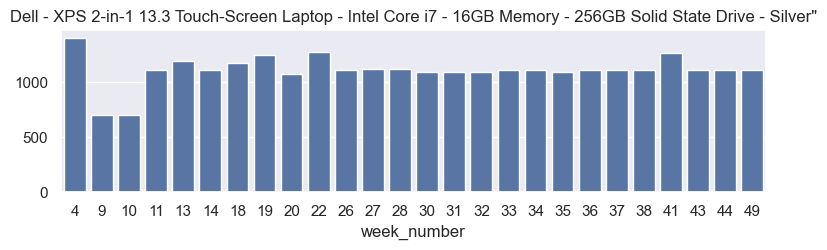

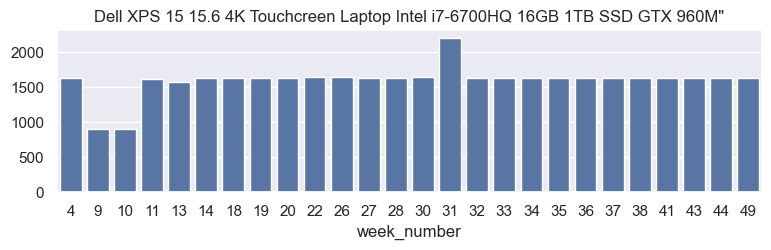

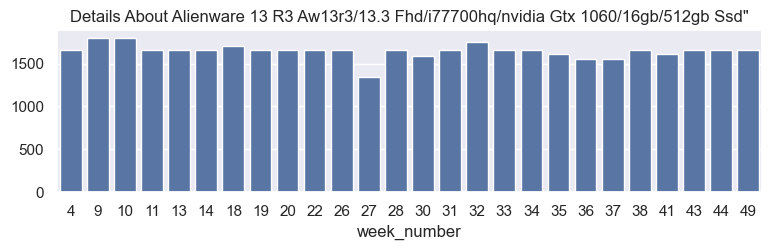

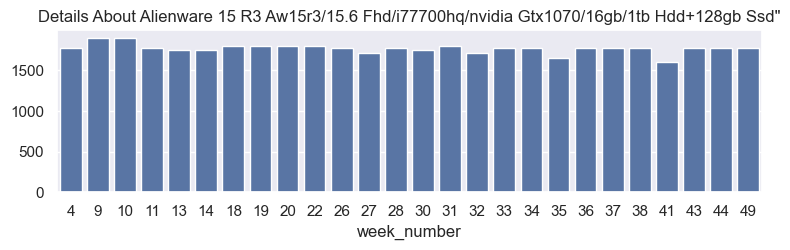

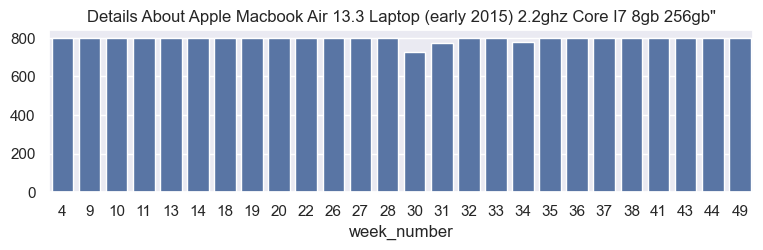

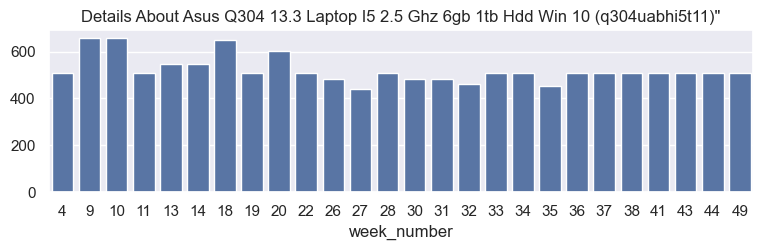

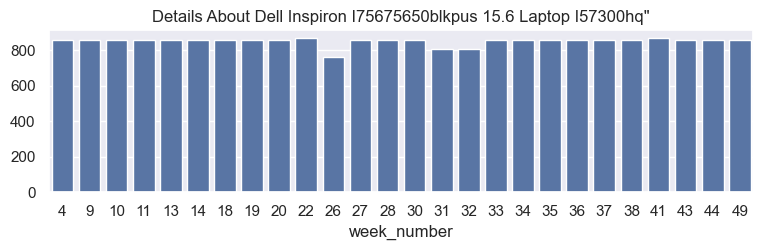

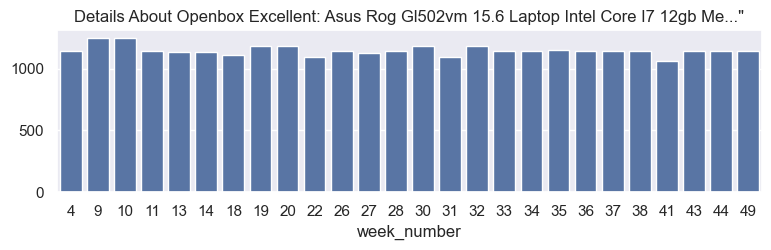

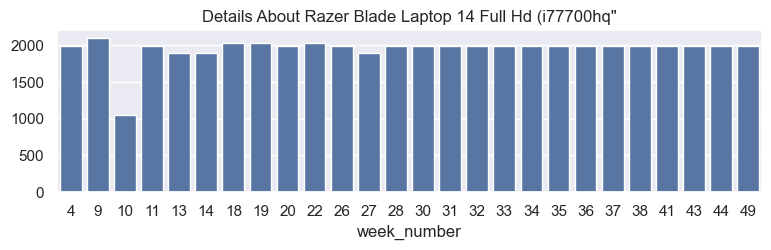

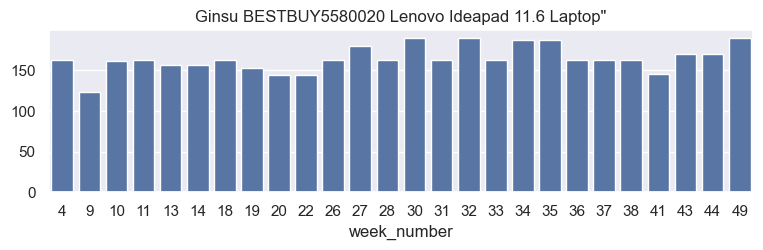

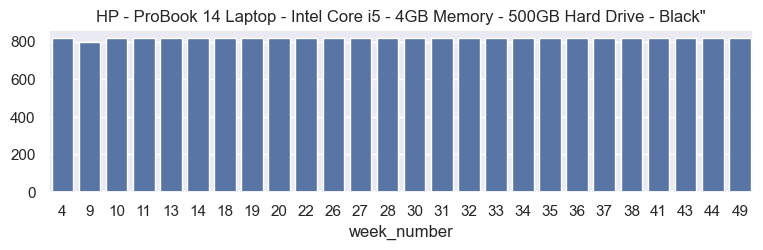

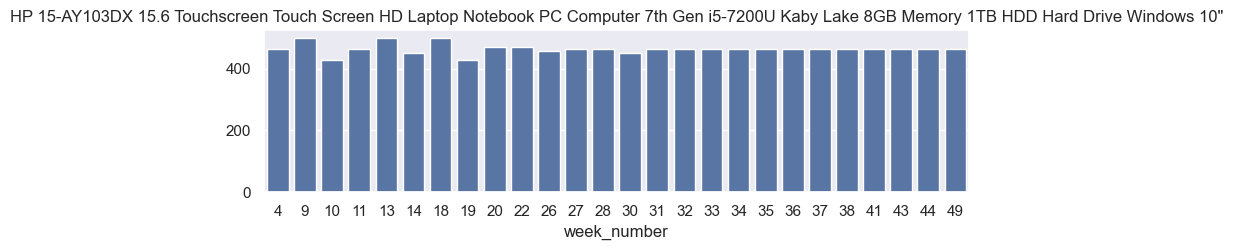

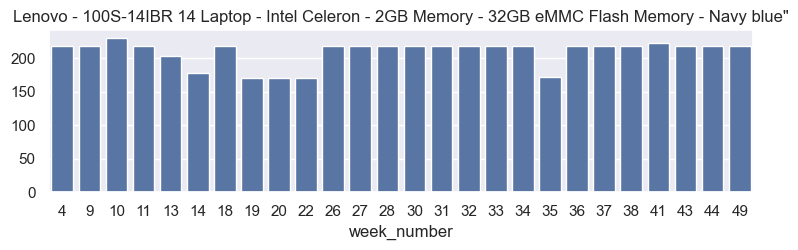

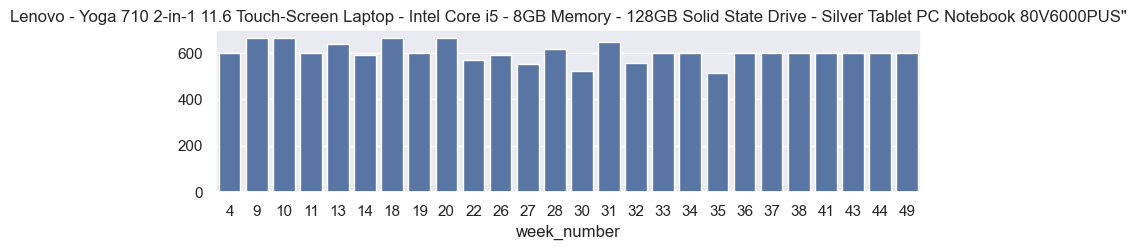

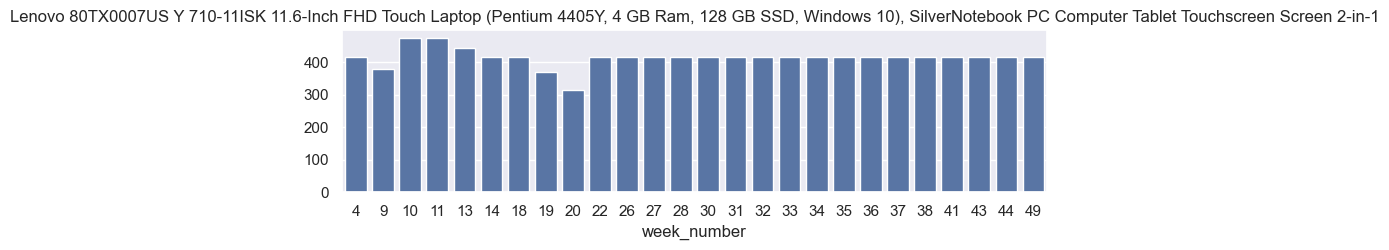

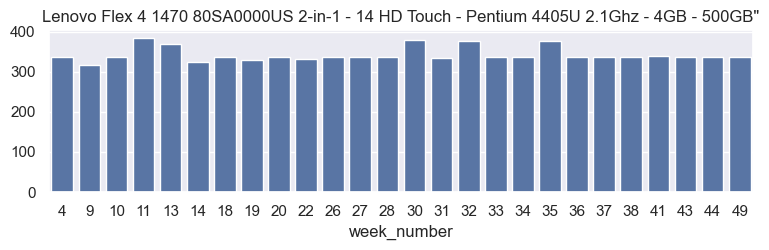

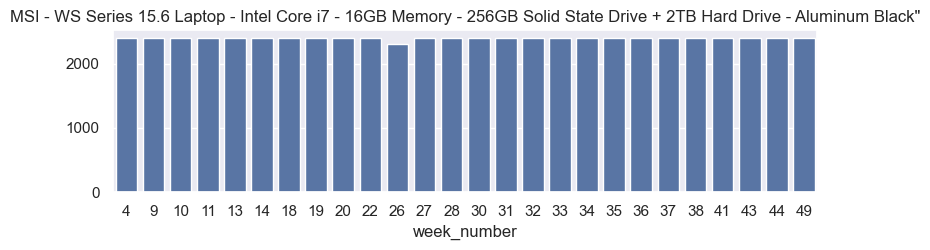

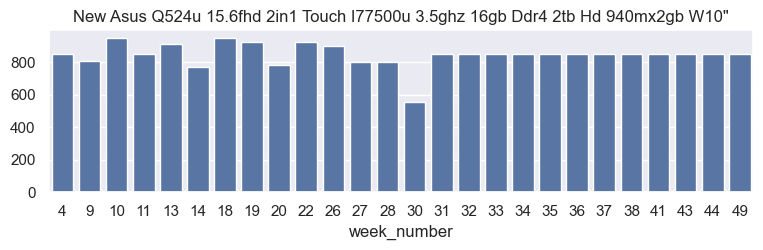

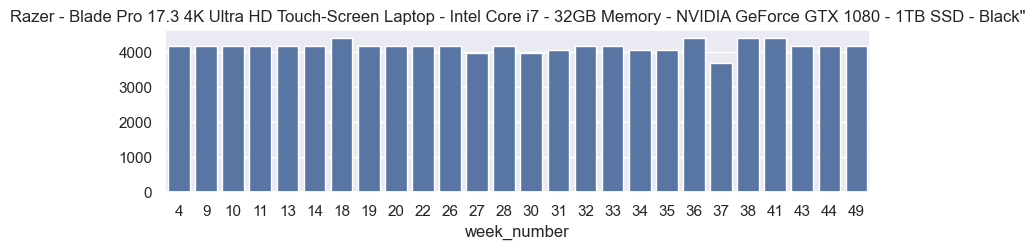

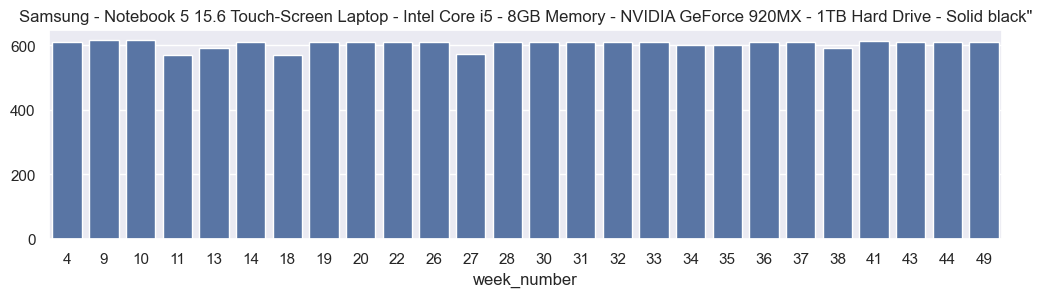

In [47]:
for k in np.arange(1, len(x_price.columns),1):
    plt.figure(figsize=(20,50))
    plt.subplot(20,2,k)
    sns.barplot(data=x_price, x=x_price['week_number'], y=x_price[x_price.columns[k]])
    plt.title(a[k])
    plt.ylabel('')
plt.tight_layout()


C:\Users\nerod\AppData\Local\Temp\ipykernel_6720\3804727478.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(20,50))


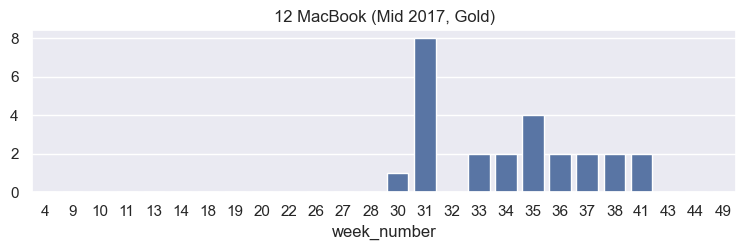

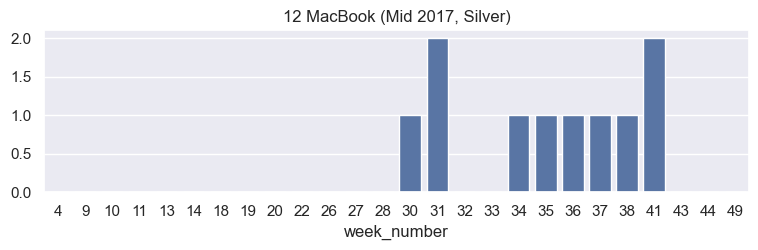

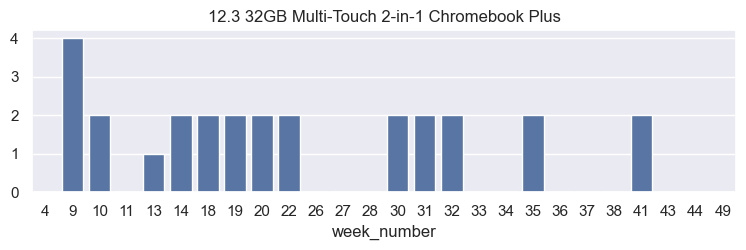

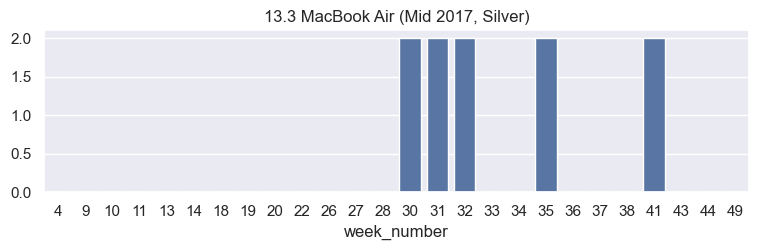

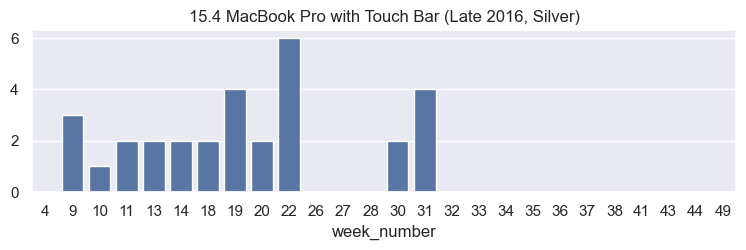

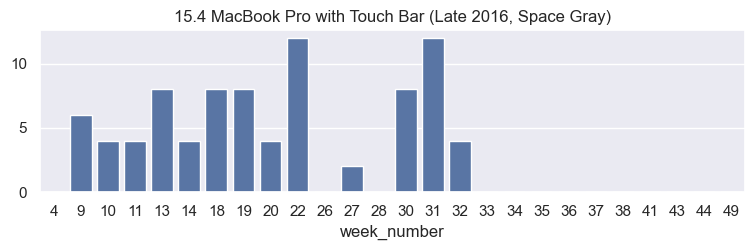

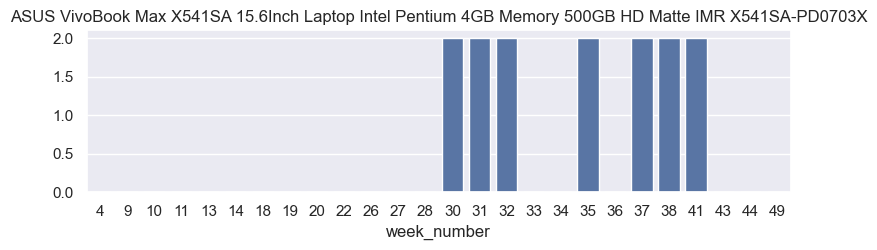

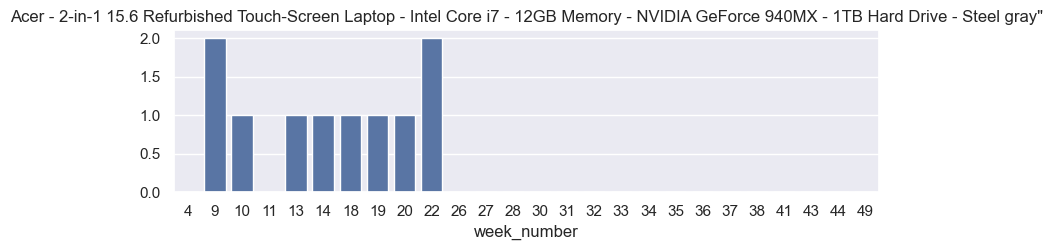

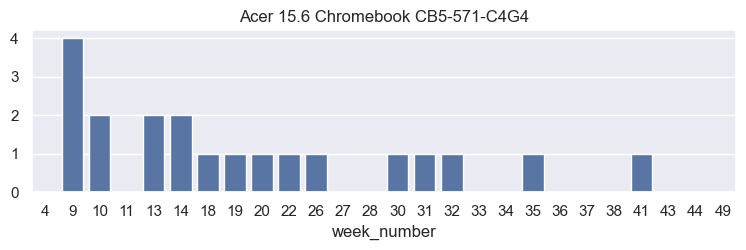

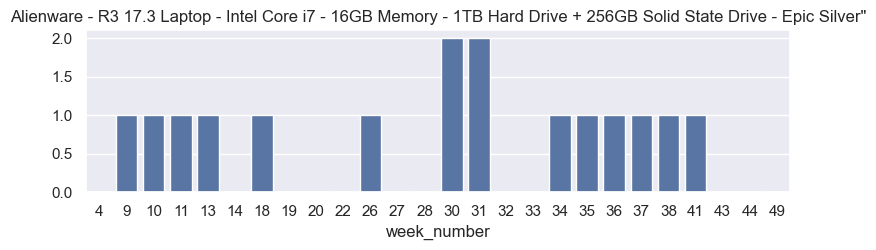

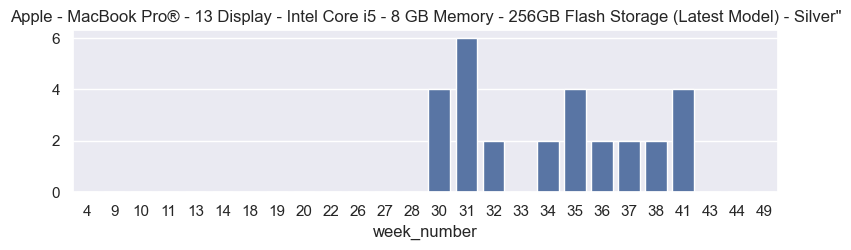

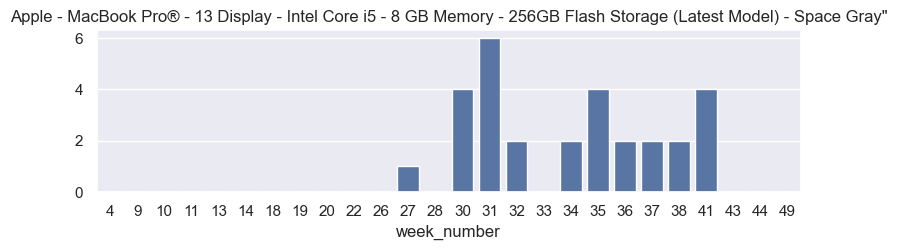

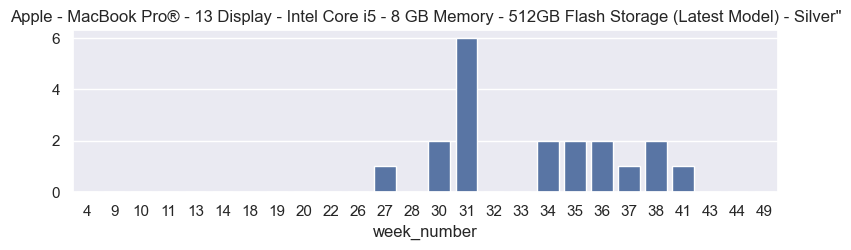

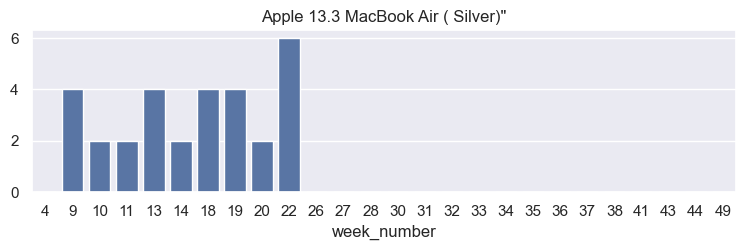

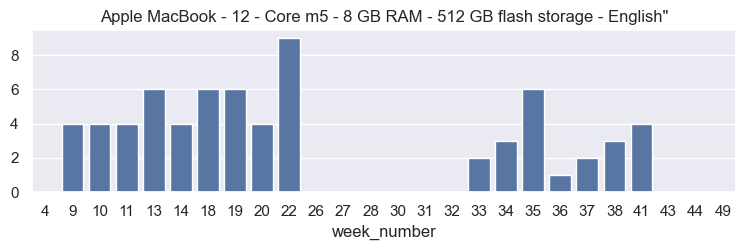

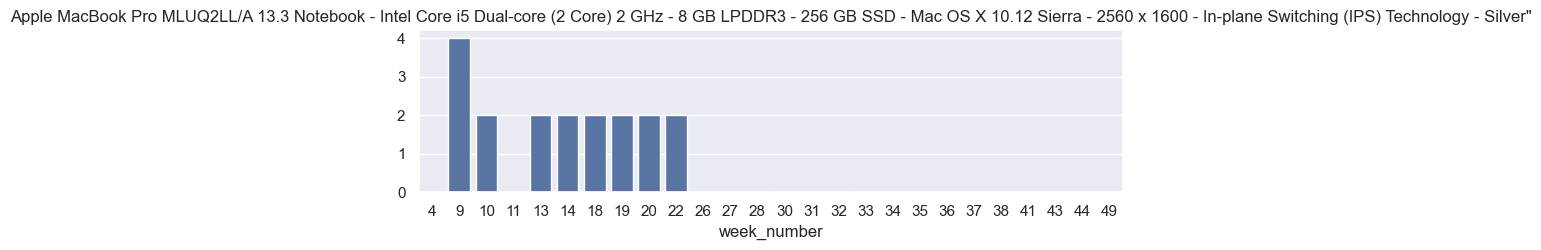

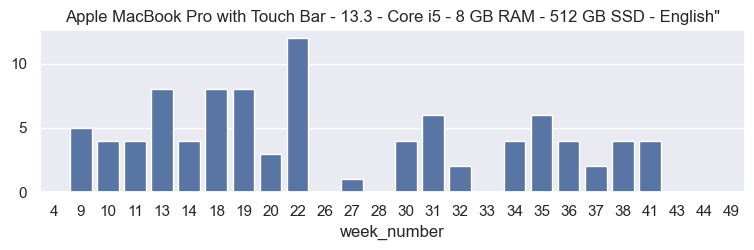

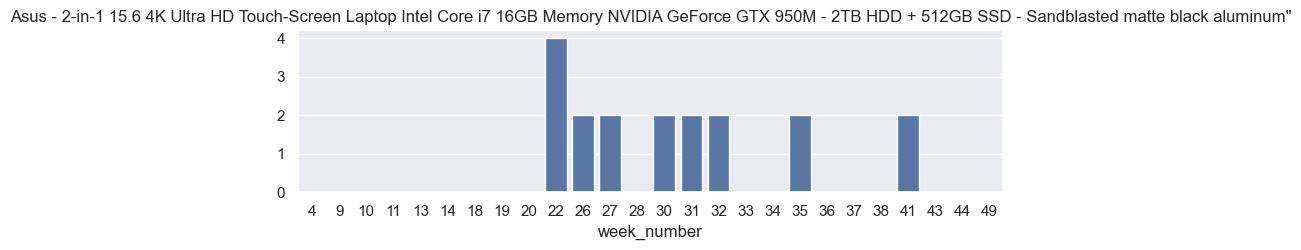

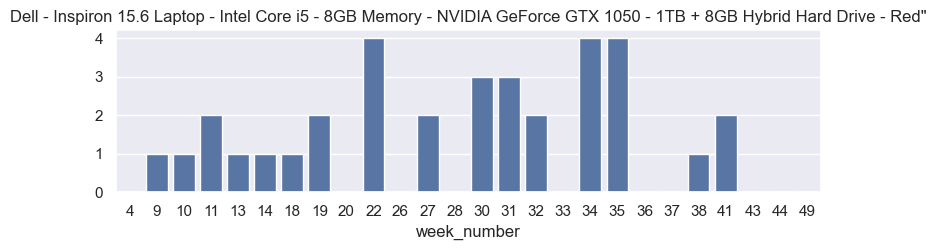

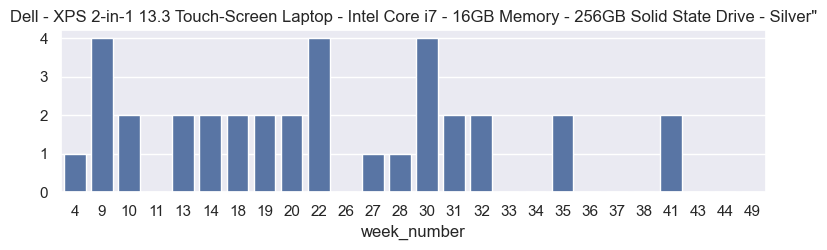

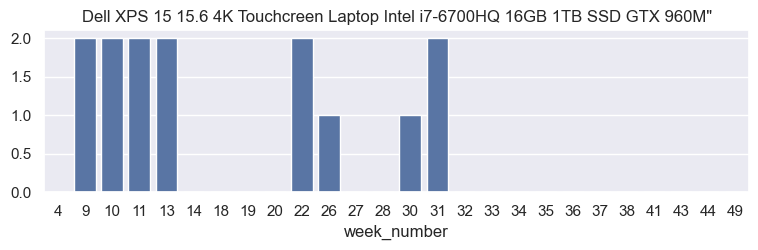

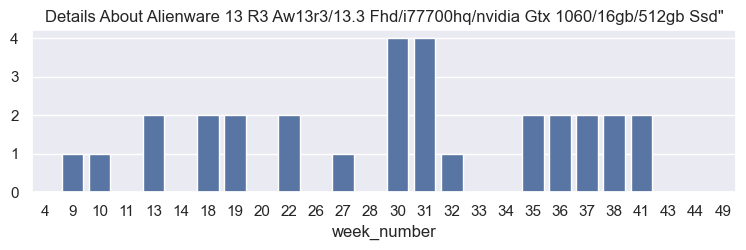

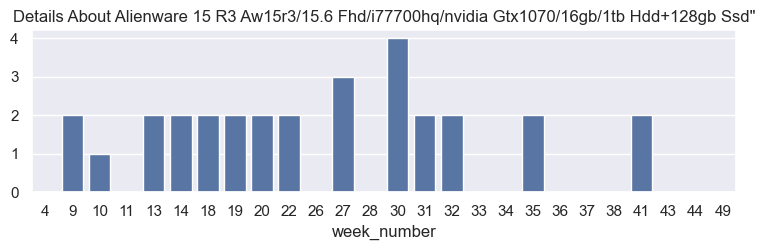

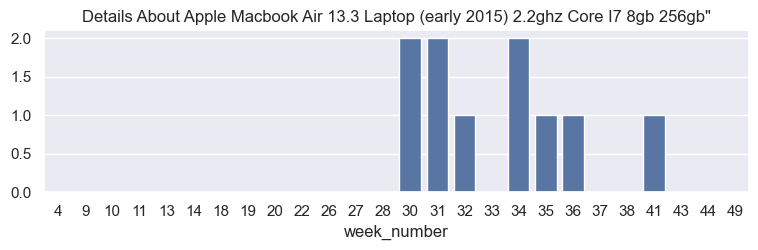

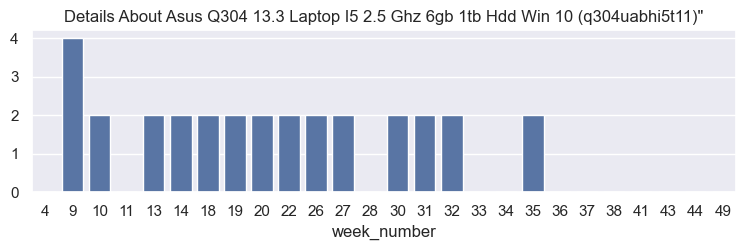

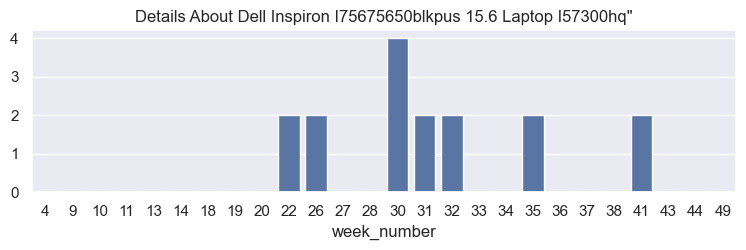

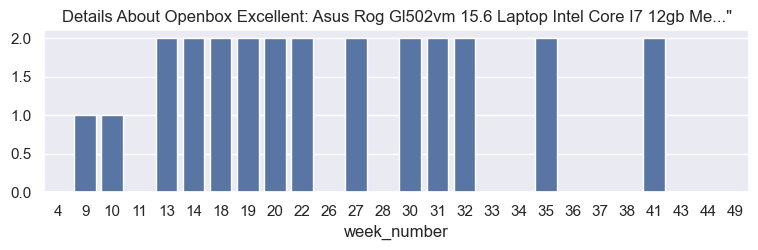

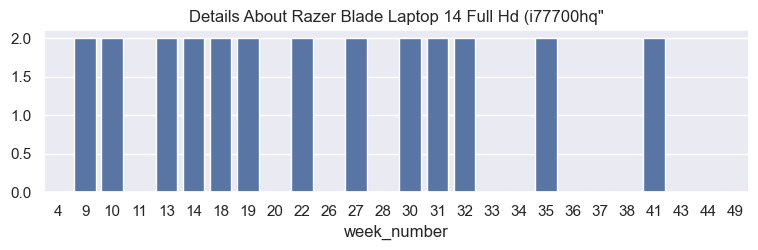

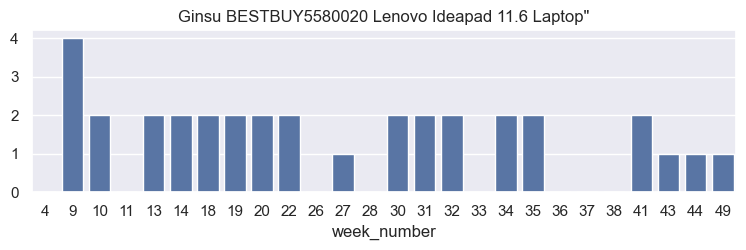

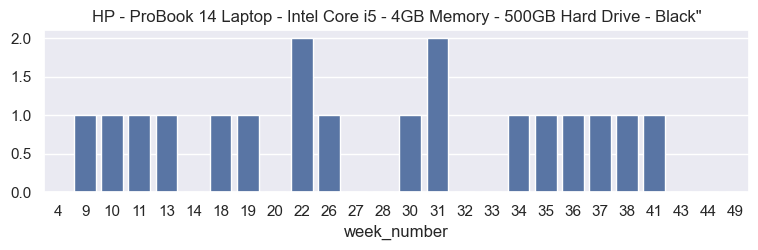

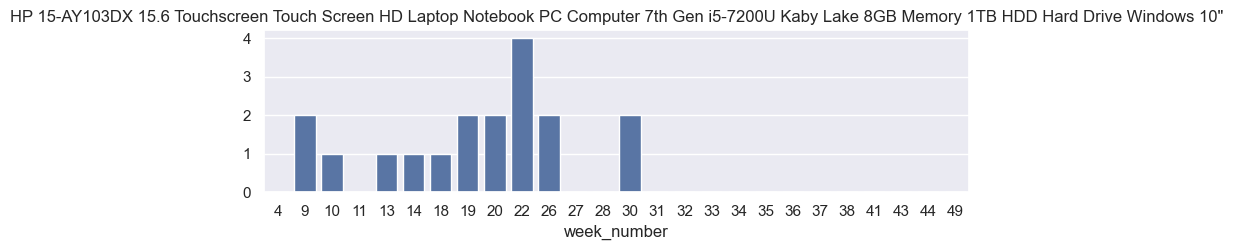

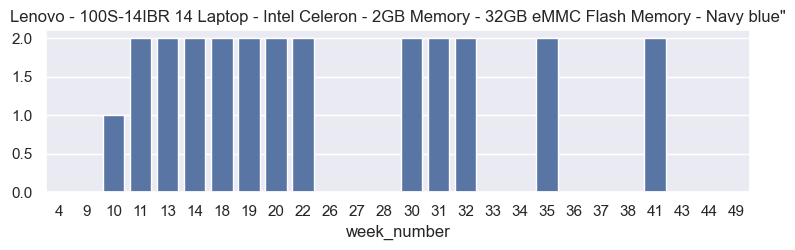

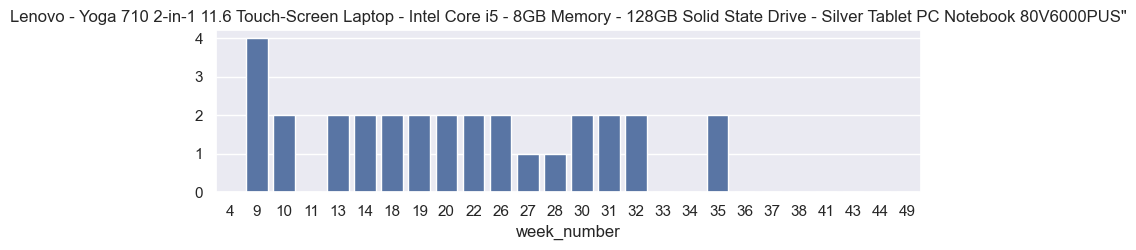

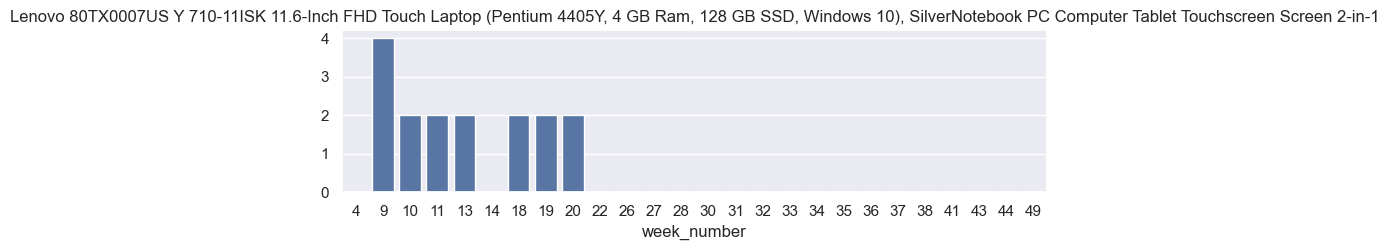

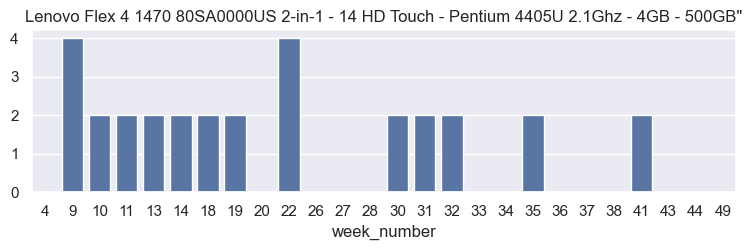

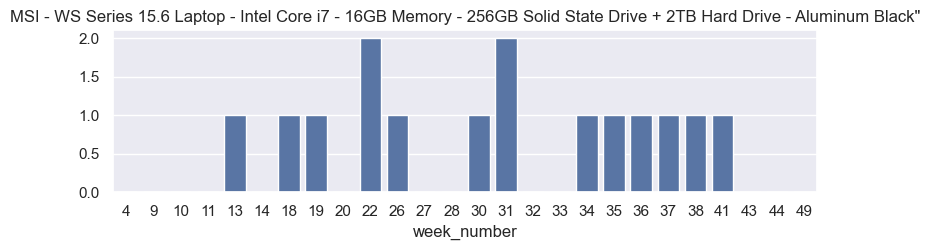

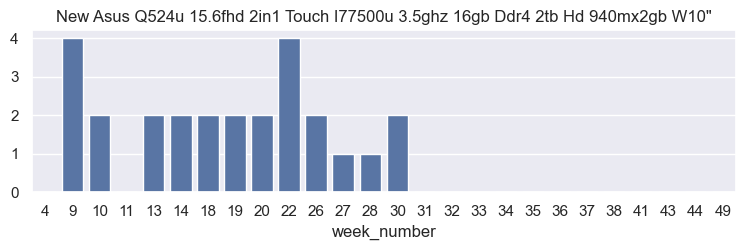

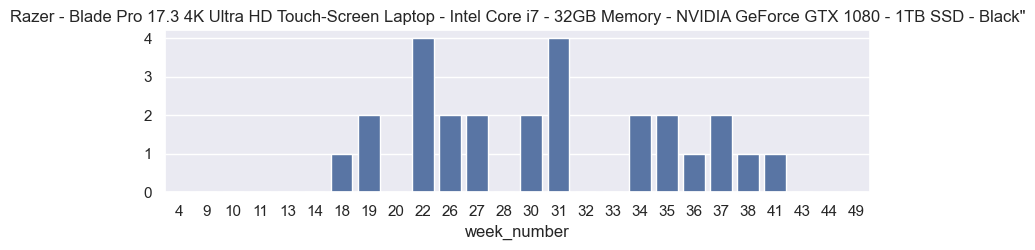

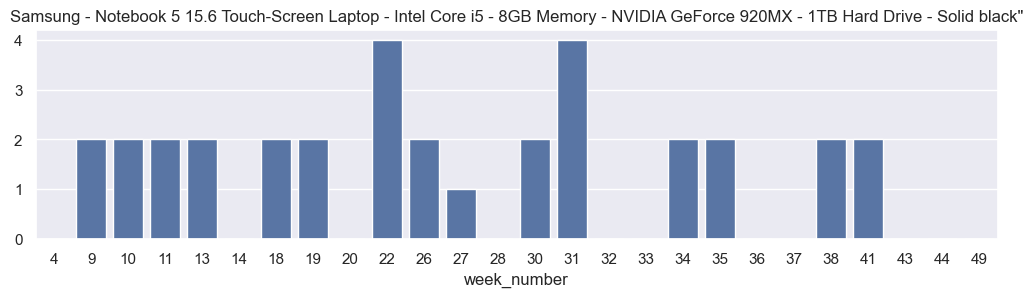

In [48]:
plt.close('all')
for k in np.arange(1, len(y_demand.columns),1):
    plt.figure(figsize=(20,50))
    plt.subplot(20,2,k)
    sns.barplot(data=x_price, x=y_demand['week_number'], y=y_demand[y_demand.columns[k]])
    plt.title(a[k])
    plt.ylabel('')
plt.tight_layout()

# 6.0 Model ML

In [50]:
x_laptop = x_price['12 MacBook (Mid 2017, Silver)']
y_laptop = y_demand['12 MacBook (Mid 2017, Silver)']
x_laptop = sm.add_constant(x_laptop)
model = sm.OLS(y_laptop, x_laptop)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     12 MacBook (Mid 2017, Silver)   R-squared:                       0.196
Model:                                       OLS   Adj. R-squared:                  0.163
Method:                            Least Squares   F-statistic:                     5.852
Date:                           Tue, 17 Oct 2023   Prob (F-statistic):             0.0235
Time:                                   16:26:12   Log-Likelihood:                -21.833
No. Observations:                             26   AIC:                             47.67
Df Residuals:                                 24   BIC:                             50.18
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            25.4291     10.354      2.456      0.022       4.060      46.798
12 MacBook (Mid 2017, Silver)    -0.0193      0.008     -2.419      0.024      -0.036      -0.003
==============================================================================
Omnibus:                       11.642   Durbin-Watson:                   1.442
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               10.337
Skew:                           1.451   Prob(JB):                      0.00569
Kurtosis:                       4.057   Cond. No.                     1.17e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [51]:
results_values_laptop = {
    'name': [],
    'price_elasticity': [],
    'price_mean': [],
    'quantity_mean': [],
    'intercept': [],
    'slope': [],
    'rsquared': [],
    'p_value': [],
    'residual_std':[],
    'durbin_watson_statistic':[]
    
    
}

for column in x_price.columns[1:]:
    column_points = []
    for i in range(len(x_price[column])):
        column_points.append((x_price[column][i],y_demand[column][i]))
    df = pd.DataFrame(list(column_points), columns=['x_price', 'y_demand'])
    x_laptop = df['x_price']
    y_laptop = df['y_demand']
    x_laptop = sm.add_constant(x_laptop)
    model = sm.OLS(y_laptop, x_laptop)
    results = model.fit()
    
    if results.f_pvalue < 0.05:
        
        rsquared = results.rsquared
        p_value = results.f_pvalue
        intercept, slope = results.params
        mean_price = np.mean(x_laptop)
        mean_quantity = np.mean(y_laptop)
        residual_std = np.std(results.resid)
        
        # Interpretar o valor do teste de Durbin-Watson
        # O valor do teste de Durbin-Watson varia entre 0 e 4.
        # Valores próximos a 2 indicam ausência de autocorrelação.
        # Valores menores que 2 indicam autocorrelação positiva.
        # Valores maiores que 2 indicam autocorrelação negativa.
        durbin_watson_statistic = durbin_watson(results.resid)

        
        
        
        price_elasticity = slope*( mean_price / mean_quantity)

        
        
        results_values_laptop['name'].append(column)
        results_values_laptop['price_elasticity'].append(price_elasticity)
        results_values_laptop['price_mean'].append(mean_price)
        results_values_laptop['quantity_mean'].append(mean_quantity)
        results_values_laptop['intercept'].append(intercept)
        results_values_laptop['slope'].append(slope)
        results_values_laptop['rsquared'].append(rsquared)
        results_values_laptop['p_value'].append(p_value)
        results_values_laptop['residual_std'].append(residual_std)
        results_values_laptop['durbin_watson_statistic'].append(durbin_watson_statistic)
        
        
    df_elasticity = pd.DataFrame.from_dict(results_values_laptop)
        
        
        
        
        

In [52]:
df_elasticity

name  price_elasticity  price_mean  quantity_mean  intercept     slope  rsquared   p_value  residual_std  durbin_watson_statistic
0                      12 MacBook (Mid 2017, Silver)        -32.582920  648.495000       0.384615  25.429075 -0.019325  0.196027  0.023508      0.560337                 1.441751
1  ASUS VivoBook Max X541SA 15.6Inch Laptop Intel...         -8.046579  150.360385       0.538462   9.175192 -0.028816  0.281984  0.005251      0.751708                 1.262270
2                  Acer 15.6 Chromebook CB5-571-C4G4         -4.233661  121.739615       0.769231   7.255804 -0.026751  0.161645  0.041743      0.853944                 1.614007
3  Apple MacBook Pro MLUQ2LL/A 13.3 Notebook - In...         -3.011779  612.610577       0.692308   4.859060 -0.003404  0.236464  0.011774      0.962384                 0.718310
4  Dell - Inspiron 15.6 Laptop - Intel Core i5 - ...        -11.616440  395.879615       1.307692  31.650779 -0.038372  0.327839  0.002237      1.108594                 1.759995
5  Details About Apple Macbook Air 13.3 Laptop (e...        -34.125706  398.254615       0.384615  26.602201 -0.032957  0.510312  0.000041      0.478443                 1.455800
6  Lenovo - 100S-14IBR 14 Laptop - Intel Celeron ...         -3.039126  105.331538       0.961538   6.778268 -0.027743  0.277667  0.005677      0.832756                 1.357853

# 7.0 Elasticity

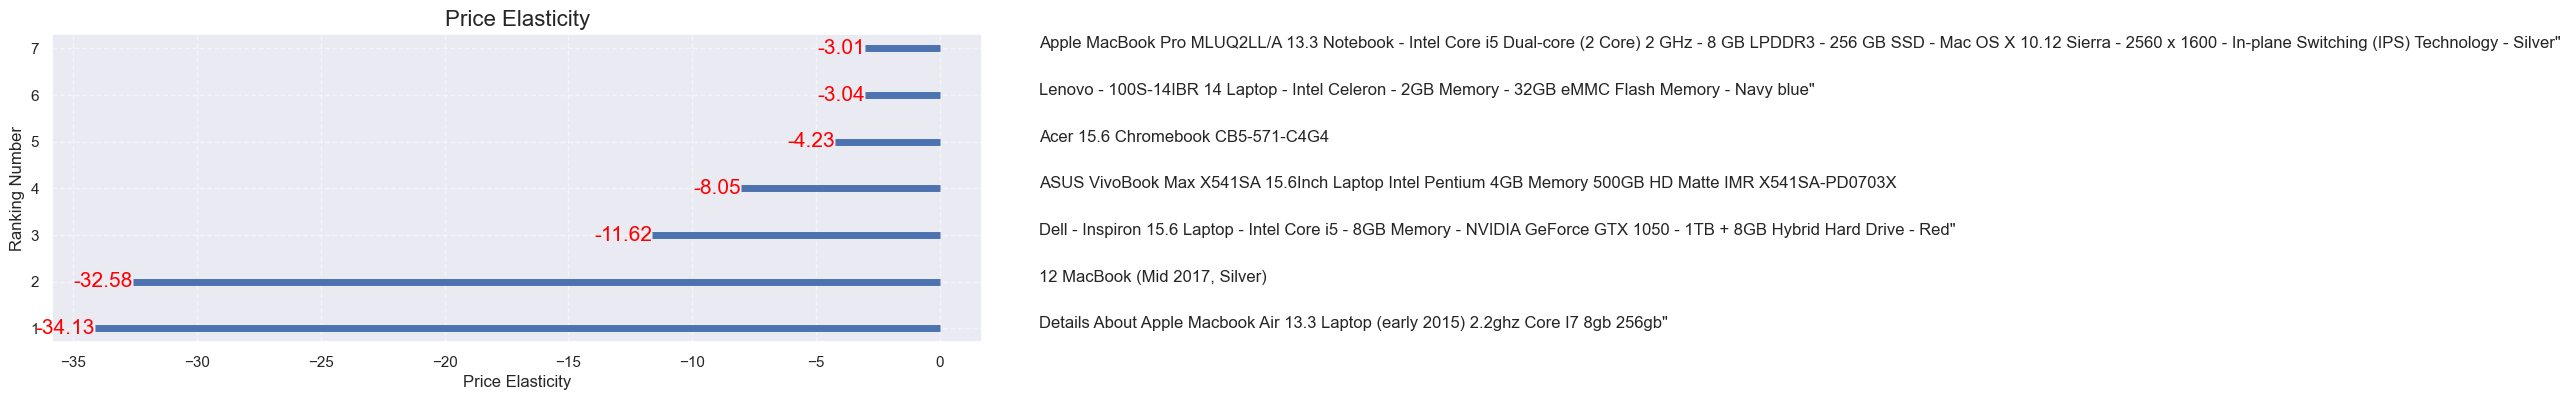

In [54]:
df_elasticity['ranking'] = df_elasticity.loc[:, 'price_elasticity'].rank(ascending=True).astype(int)
df_elasticity = df_elasticity.reset_index(drop=True)
df_elasticity

plt.figure(figsize=(12,4))
plt.hlines(y=df_elasticity['ranking'], xmin=0, xmax=df_elasticity['price_elasticity'], alpha=1, linewidth=5)

for name, p in zip(df_elasticity['name'], df_elasticity['ranking']):
    plt.text(4, p, name)

for x, y, s in zip(df_elasticity['price_elasticity'], df_elasticity['ranking'], df_elasticity['price_elasticity']):
    plt.text(x, y, round(s, 2), horizontalalignment='right' if x<0 else 'left',
                                verticalalignment='center',
                                fontdict={'color':'red' if x<0 else 'green', 'size':15})
plt.gca().set(ylabel='Ranking Number', xlabel='Price Elasticity')
plt.title('Price Elasticity', fontsize=16)
#plt.title('Price Elasticity')
plt.grid(linestyle='--', alpha=0.5)


In [55]:
df_order_elasticity = df_elasticity[['ranking', 'name', 'price_elasticity']].sort_values(by='price_elasticity', ascending=False)
df_order_elasticity

ranking                                               name  price_elasticity
3        7  Apple MacBook Pro MLUQ2LL/A 13.3 Notebook - In...         -3.011779
6        6  Lenovo - 100S-14IBR 14 Laptop - Intel Celeron ...         -3.039126
2        5                  Acer 15.6 Chromebook CB5-571-C4G4         -4.233661
1        4  ASUS VivoBook Max X541SA 15.6Inch Laptop Intel...         -8.046579
4        3  Dell - Inspiron 15.6 Laptop - Intel Core i5 - ...        -11.616440
0        2                      12 MacBook (Mid 2017, Silver)        -32.582920
5        1  Details About Apple Macbook Air 13.3 Laptop (e...        -34.125706

# 8.0 Business Performance

In [57]:
result_faturamento = {
    'name': [],
    'faturamento_atual': [],
    'faturamento_reducao': [],
    'perda_faturamento': [],
    'faturamento_novo': [],
    'variacao_faturamento': [],
    'variacao_percentual': []
    
}

for i in range( len(df_order_elasticity)):
    preco_atual_medio = x_price[df_order_elasticity['name'][i]].mean()
    demanda_atual = y_demand[df_order_elasticity['name'][i]].sum()
    
    reducao_preco = preco_atual_medio * 0.9
    aumento_demanda = -0.1 * df_order_elasticity['price_elasticity'][i]
    
    demanda_nova = aumento_demanda * demanda_atual
    
    faturamento_atual = round(preco_atual_medio*demanda_atual, 2)
    faturamento_novo = reducao_preco*demanda_nova
    
    faturamento_reducao = round(faturamento_atual*0.9, 2)
    
    perda_faturamento = round(faturamento_atual-faturamento_novo, 2)
    
    variacao_faturamento = round(faturamento_novo - faturamento_atual, 2)    
    
    variacao_percentual = round(((faturamento_novo - faturamento_atual)/faturamento_atual)*100, 2)
    
    result_faturamento['name'].append(df_order_elasticity['name'][i])
    result_faturamento['faturamento_atual'].append(faturamento_atual)
    result_faturamento['faturamento_reducao'].append(faturamento_reducao)
    result_faturamento['perda_faturamento'].append(perda_faturamento)
    result_faturamento['faturamento_novo'].append(faturamento_novo)
    result_faturamento['variacao_faturamento'].append(variacao_faturamento)
    result_faturamento['variacao_percentual'].append(variacao_percentual)

result_var = pd.DataFrame(result_faturamento)
result_var

name  faturamento_atual  faturamento_reducao  perda_faturamento  faturamento_novo  variacao_faturamento  variacao_percentual
0                      12 MacBook (Mid 2017, Silver)           12959.90             11663.91          -25044.52      38004.424073              25044.52               193.25
1  ASUS VivoBook Max X541SA 15.6Inch Laptop Intel...            4196.09              3776.48            1157.31       3038.775849              -1157.31               -27.58
2                  Acer 15.6 Chromebook CB5-571-C4G4            4849.58              4364.62            3001.75       1847.834577              -3001.75               -61.90
3  Apple MacBook Pro MLUQ2LL/A 13.3 Notebook - In...           22035.98             19832.38           16062.90       5973.075897             -16062.90               -72.89
4  Dell - Inspiron 15.6 Laptop - Intel Core i5 - ...           26885.81             24197.23           -1222.76      28108.570270               1222.76                 4.55
5  Details About Apple Macbook Air 13.3 Laptop (e...            7955.09              7159.58          -16477.49      24432.582560              16477.49               207.13
6  Lenovo - 100S-14IBR 14 Laptop - Intel Celeron ...            5241.58              4717.42            3807.90       1433.683058              -3807.90               -72.65

# 9.0 Cross Price Elasticity

In [97]:
new_df = x_price.copy()

new_df['y_value-'+'12 MacBook (Mid 2017, Silver)'] = y_demand['12 MacBook (Mid 2017, Silver)']


multi_xvalues =new_df.loc[:, new_df.columns[1:-1]]
multi_yvalues = new_df.loc[:, new_df.columns[-1]]

# obter o valor médio do preço do produto
mean_xvalues = np.mean(multi_xvalues)
# obter o valor médio da demanda do produto
mean_yvalues = np.mean(multi_yvalues)


    # regressão linear
X = sm.add_constant(multi_xvalues)
model = sm.OLS(multi_yvalues, X, missing='drop')
result = model.fit()


result_summary = result.summary()
pvalue = result.pvalues

# transformando o resultado em uma dataframe
results_as_html = result_summary.tables[1].as_html()

results_as_io = StringIO(results_as_html)
new_dataframe = pd.read_html(results_as_io, header=0, index_col=0)[0]

#adicionando o p-valor ao dataframe
new_dataframe['p_value'] = pvalue

#definindo o nome do produto como indice
new_dataframe.index.name = 'name'
new_dataframe.reset_index()

#calculando a elasticidade cruzada
new_dataframe['mean'] = mean_xvalues
new_dataframe['price_elasticity'] = round((new_dataframe.coef)*(new_dataframe['mean']/mean_yvalues), 2)



new_dataframe = new_dataframe.reset_index()

pvalue_siginicant = new_dataframe['p_value']



new_dataframe['12 MacBook (Mid 2017, Silver)'+'CPE'] = np.where((pvalue_siginicant>0.05),'No Effect', new_dataframe['price_elasticity'])
new_dataframe = new_dataframe.dropna()



In [98]:
 def crossprice ( df_x, df_y, column_name):
    
    new_df = x_price.copy()
    
    new_df['y_value-'+column_name] = y_demand[column_name]
    
    
    multi_xvalues =new_df.loc[:, new_df.columns[1:-1]]
    multi_yvalues = new_df.loc[:, new_df.columns[-1]]
    
    # obter o valor médio do preço do produto
    mean_xvalues = np.mean(multi_xvalues)
    # obter o valor médio da demanda do produto
    mean_yvalues = np.mean(multi_yvalues)
    
    
        # regressão linear
    X = sm.add_constant(multi_xvalues)
    model = sm.OLS(multi_yvalues, X, missing='drop')
    result = model.fit()
    
    
    result_summary = result.summary()
    pvalue = result.pvalues
    
    # transformando o resultado em uma dataframe
    results_as_html = result_summary.tables[1].as_html()
    
    results_as_io = StringIO(results_as_html)
    new_dataframe = pd.read_html(results_as_io, header=0, index_col=0)[0]
    
    #adicionando o p-valor ao dataframe
    new_dataframe['p_value'] = pvalue
    
    #definindo o nome do produto como indice
    new_dataframe.index.name = 'name'
    new_dataframe.reset_index()
    
    #calculando a elasticidade cruzada
    new_dataframe['mean'] = mean_xvalues
    new_dataframe['price_elasticity'] = round((new_dataframe.coef)*(new_dataframe['mean']/mean_yvalues), 2)
    
    
    
    new_dataframe = new_dataframe.reset_index()
    
    pvalue_siginicant = new_dataframe['p_value']
    
    
    
    new_dataframe[column_name+'CPE'] = np.where((pvalue_siginicant>0.05),'No Effect', new_dataframe['price_elasticity'])
    new_dataframe = new_dataframe.dropna()
    
    return new_dataframe[['name', column_name + 'CPE']]

In [99]:
result_df = pd.DataFrame()
for column in x_price.columns[1:]:
    result_df[['name', column +'CPE']] = crossprice(x_price, y_demand, column)

result_df = result_df.set_index('name')

In [100]:
result_df

12 MacBook (Mid 2017, Gold)CPE 12 MacBook (Mid 2017, Silver)CPE 12.3 32GB Multi-Touch 2-in-1 Chromebook PlusCPE 13.3 MacBook Air (Mid 2017, Silver)CPE 15.4 MacBook Pro with Touch Bar (Late 2016, Silver)CPE 15.4 MacBook Pro with Touch Bar (Late 2016, Space Gray)CPE ASUS VivoBook Max X541SA 15.6Inch Laptop Intel Pentium 4GB Memory 500GB HD Matte IMR X541SA-PD0703XCPE Acer - 2-in-1 15.6 Refurbished Touch-Screen Laptop - Intel Core i7 - 12GB Memory - NVIDIA GeForce 940MX - 1TB Hard Drive - Steel gray"CPE Acer 15.6 Chromebook CB5-571-C4G4CPE Alienware - R3 17.3 Laptop - Intel Core i7 - 16GB Memory - 1TB Hard Drive + 256GB Solid State Drive - Epic Silver"CPE Apple - MacBook Pro® - 13 Display - Intel Core i5 - 8 GB Memory - 256GB Flash Storage (Latest Model) - Silver"CPE Apple - MacBook Pro® - 13 Display - Intel Core i5 - 8 GB Memory - 256GB Flash Storage (Latest Model) - Space Gray"CPE Apple - MacBook Pro® - 13 Display - Intel Core i5 - 8 GB Memory - 512GB Flash Storage (Latest Model) - Silver"CPE Apple 13.3 MacBook Air ( Silver)"CPE Apple MacBook - 12 - Core m5 - 8 GB RAM - 512 GB flash storage - English"CPE Apple MacBook Pro MLUQ2LL/A 13.3 Notebook - Intel Core i5 Dual-core (2 Core) 2 GHz - 8 GB LPDDR3 - 256 GB SSD - Mac OS X 10.12 Sierra - 2560 x 1600 - In-plane Switching (IPS) Technology - Silver"CPE Apple MacBook Pro with Touch Bar - 13.3 - Core i5 - 8 GB RAM - 512 GB SSD - English"CPE Asus - 2-in-1 15.6 4K Ultra HD Touch-Screen Laptop Intel Core i7 16GB Memory NVIDIA GeForce GTX 950M - 2TB HDD + 512GB SSD - Sandblasted matte black aluminum"CPE Dell - Inspiron 15.6 Laptop - Intel Core i5 - 8GB Memory - NVIDIA GeForce GTX 1050 - 1TB + 8GB Hybrid Hard Drive - Red"CPE Dell - XPS 2-in-1 13.3 Touch-Screen Laptop - Intel Core i7 - 16GB Memory - 256GB Solid State Drive - Silver"CPE Dell XPS 15 15.6 4K Touchcreen Laptop Intel i7-6700HQ 16GB 1TB SSD GTX 960M"CPE Details About Alienware 13 R3 Aw13r3/13.3 Fhd/i77700hq/nvidia Gtx 1060/16gb/512gb Ssd"CPE Details About Alienware 15 R3 Aw15r3/15.6 Fhd/i77700hq/nvidia Gtx1070/16gb/1tb Hdd+128gb Ssd"CPE Details About Apple Macbook Air 13.3 Laptop (early 2015) 2.2ghz Core I7 8gb 256gb"CPE Details About Asus Q304 13.3 Laptop I5 2.5 Ghz 6gb 1tb Hdd Win 10 (q304uabhi5t11)"CPE Details About Dell Inspiron I75675650blkpus 15.6 Laptop I57300hq"CPE Details About Openbox Excellent: Asus Rog Gl502vm 15.6 Laptop Intel Core I7 12gb Me..."CPE Details About Razer Blade Laptop 14 Full Hd (i77700hq"CPE Ginsu BESTBUY5580020 Lenovo Ideapad 11.6 Laptop"CPE HP - ProBook 14 Laptop - Intel Core i5 - 4GB Memory - 500GB Hard Drive - Black"CPE HP 15-AY103DX 15.6 Touchscreen Touch Screen HD Laptop Notebook PC Computer 7th Gen i5-7200U Kaby Lake 8GB Memory 1TB HDD Hard Drive Windows 10"CPE Lenovo - 100S-14IBR 14 Laptop - Intel Celeron - 2GB Memory - 32GB eMMC Flash Memory - Navy blue"CPE Lenovo - Yoga 710 2-in-1 11.6 Touch-Screen Laptop - Intel Core i5 - 8GB Memory - 128GB Solid State Drive - Silver Tablet PC Notebook 80V6000PUS"CPE Lenovo 80TX0007US Y 710-11ISK 11.6-Inch FHD Touch Laptop (Pentium 4405Y, 4 GB Ram, 128 GB SSD, Windows 10), SilverNotebook PC Computer Tablet Touchscreen Screen 2-in-1CPE Lenovo Flex 4 1470 80SA0000US 2-in-1 - 14 HD Touch - Pentium 4405U 2.1Ghz - 4GB - 500GB"CPE MSI - WS Series 15.6 Laptop - Intel Core i7 - 16GB Memory - 256GB Solid State Drive + 2TB Hard Drive - Aluminum Black"CPE New Asus Q524u 15.6fhd 2in1 Touch I77500u 3.5ghz 16gb Ddr4 2tb Hd 940mx2gb W10"CPE Razer - Blade Pro 17.3 4K Ultra HD Touch-Screen Laptop - Intel Core i7 - 32GB Memory - NVIDIA GeForce GTX 1080 - 1TB SSD - Black"CPE Samsung - Notebook 5 15.6 Touch-Screen Laptop - Intel Core i5 - 8GB Memory - NVIDIA GeForce 920MX - 1TB Hard Drive - Solid black"CPE
name                                                                                                                                                                                                                                                                              

# Deploy